In [ ]:

# Moscow Housing
# Kaggle team name: Group 20
# Adi Bhatnagar: 507413
# Alf Berger Husem: 507574
# Yuheng He: 567187

In [ ]:
import json
import pandas as pd
import numpy as np
import math as math
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.model_selection as model_selection
import sklearn.tree as tree
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
import time
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor


In [ ]:

np.random.seed(123)
sns.set_style('darkgrid')
pd.set_option('display.max_colwidth', None)

def describe_column(meta):
    """
    Utility function for describing a dataset column (see below for usage)
    """
    def f(x):
        d = pd.Series(name=x.name, dtype=object)
        m = next(m for m in meta if m['name'] == x.name)
        d['Type'] = m['type']
        d['#NaN'] = x.isna().sum()
        d['Description'] = m['desc']
        if m['type'] == 'categorical':
            counts = x.dropna().map(dict(enumerate(m['cats']))).value_counts().sort_index()
            d['Statistics'] = ', '.join(f'{c}({n})' for c, n in counts.items())
        elif m['type'] == 'real' or m['type'] == 'integer':
            stats = x.dropna().agg(['mean', 'std', 'min', 'max'])
            d['Statistics'] = ', '.join(f'{s}={v :.1f}' for s, v in stats.items())
        elif m['type'] == 'boolean':
            counts = x.dropna().astype(bool).value_counts().sort_index()
            d['Statistics'] = ', '.join(f'{c}({n})' for c, n in counts.items())
        else:
            d['Statistics'] = f'#unique={x.nunique()}'
        return d
    return f


def describe_data(data, meta):
    desc = data.apply(describe_column(meta)).T
    desc = desc.style.set_properties(**{'text-align': 'left'})
    desc = desc.set_table_styles([ dict(selector='th', props=[('text-align', 'left')])])
    return desc


apartments = pd.read_csv('apartments_train.csv')
print(f'Loaded {len(apartments)} apartments')
with open('apartments_meta.json') as f:
    apartments_meta = json.load(f)
(describe_data(apartments, apartments_meta))

buildings = pd.read_csv('buildings_train.csv')
print(f'Loaded {len(buildings)} buildings')
with open('buildings_meta.json') as f:
    buildings_meta = json.load(f)
buildings.head()
describe_data(buildings, buildings_meta)

#print(f'All apartments have an associated building: {apartments.building_id.isin(buildings.id).all()}')
data = pd.merge(apartments, buildings.set_index('id'), how='left', left_on='building_id', right_index=True)
print(data.head())

def root_mean_squared_log_error(y_true, y_pred):
    # Alternatively: sklearn.metrics.mean_squared_log_error(y_true, y_pred) ** 0.5
    assert (y_true >= 0).all()
    assert (y_pred >= 0).all()
    log_error = np.log1p(y_pred) - np.log1p(y_true)  # Note: log1p(x) = log(1 + x)
    return np.mean(log_error ** 2) ** 0.5


Loaded 23285 apartments
Loaded 6791 buildings
   id  seller       price  area_total  area_kitchen  area_living  floor  \
0   0     3.0   7139520.0        59.2          12.5         31.0    2.0   
1   1     NaN  10500000.0        88.0          14.2         48.0   18.0   
2   2     3.0   9019650.0        78.5          22.5         40.8   12.0   
3   3     NaN  10500000.0        88.0          14.0         48.0   18.0   
4   4     NaN  13900000.0        78.0          17.0         35.0    7.0   

   rooms  layout  ceiling  ...  address  constructed  material  stories  \
0    2.0     NaN     2.65  ...   к2.5/2       2021.0       3.0      9.0   
1    3.0     1.0      NaN  ...     14к3       2010.0       3.0     25.0   
2    3.0     NaN     2.65  ...       38       2021.0       3.0     15.0   
3    3.0     NaN      NaN  ...     14к3       2010.0       3.0     25.0   
4    2.0     1.0     2.90  ...      1к3       2017.0       2.0     15.0   

   elevator_without  elevator_passenger  elevator_se

In [ ]:
# First attempt at feature-engineering, instead of longitude and latitude, we look at distance from center
# Center is defined by the provided image and heatmap
# Distance is defined by euclidean distance
c = 0 
list1 = []
for index, row in data.iterrows():
    c += 1
    px = 37.6 
    py = 55.75
    qx = row['longitude']
    qy = row['latitude']
    d = math.sqrt((px-qx)**2 + (py-qy)**2)
    list1.append(d)
data['distance'] = list1
print(data.head())

   id  seller       price  area_total  area_kitchen  area_living  floor  \
0   0     3.0   7139520.0        59.2          12.5         31.0    2.0   
1   1     NaN  10500000.0        88.0          14.2         48.0   18.0   
2   2     3.0   9019650.0        78.5          22.5         40.8   12.0   
3   3     NaN  10500000.0        88.0          14.0         48.0   18.0   
4   4     NaN  13900000.0        78.0          17.0         35.0    7.0   

   rooms  layout  ceiling  ...  constructed  material  stories  \
0    2.0     NaN     2.65  ...       2021.0       3.0      9.0   
1    3.0     1.0      NaN  ...       2010.0       3.0     25.0   
2    3.0     NaN     2.65  ...       2021.0       3.0     15.0   
3    3.0     NaN      NaN  ...       2010.0       3.0     25.0   
4    2.0     1.0     2.90  ...       2017.0       2.0     15.0   

   elevator_without  elevator_passenger  elevator_service  parking  \
0               0.0                 1.0               1.0      1.0   
1           

In [ ]:
from math import radians, cos, sin, asin, sqrt
# tried to take the earth's curvature into consideration, but the difference is almost 0, due to the small scale of a city
# ended up using regular euclian distance
def distance(lat1, lat2, lon1, lon2):
     
    # The math module contains a function named
    # radians which converts from degrees to radians.
    lon1 = radians(lon1)
    lon2 = radians(lon2)
    lat1 = radians(lat1)
    lat2 = radians(lat2)
      
    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
 
    c = 2 * asin(sqrt(a))
    
    # Radius of earth in kilometers. Use 3956 for miles
    r = 6371
      
    # calculate the result
    return(c * r)
list1 = []
for index, row in data.iterrows():
    c += 1
    px = 37.6 
    py = 55.75
    qx = row['longitude']
    qy = row['latitude']
    d = distance(qy, py, qx, qy)
    list1.append(d)
data['distance2'] = list1
print(data.head())


   id  seller       price  area_total  area_kitchen  area_living  floor  \
0   0     3.0   7139520.0        59.2          12.5         31.0    2.0   
1   1     NaN  10500000.0        88.0          14.2         48.0   18.0   
2   2     3.0   9019650.0        78.5          22.5         40.8   12.0   
3   3     NaN  10500000.0        88.0          14.0         48.0   18.0   
4   4     NaN  13900000.0        78.0          17.0         35.0    7.0   

   rooms  layout  ceiling  ...  material  stories  elevator_without  \
0    2.0     NaN     2.65  ...       3.0      9.0               0.0   
1    3.0     1.0      NaN  ...       3.0     25.0               0.0   
2    3.0     NaN     2.65  ...       3.0     15.0               0.0   
3    3.0     NaN      NaN  ...       3.0     25.0               0.0   
4    2.0     1.0     2.90  ...       2.0     15.0               0.0   

   elevator_passenger  elevator_service  parking  garbage_chute  heating  \
0                 1.0               1.0      1

In [ ]:
# started doing simple training with only latitude and longitude, and DecissionTreeRegressor as model
data_train, data_valid = model_selection.train_test_split(data, test_size=0.33, stratify=np.log(data.price).round())
X_train = data_train[['latitude', 'longitude']]
y_train = data_train.loc[X_train.index].price
X_valid = data_valid[['latitude', 'longitude']]
y_valid = data_valid.loc[X_valid.index].price

model = tree.DecisionTreeRegressor().fit(X_train, y_train)

y_train_hat = model.predict(X_train)
y_valid_hat = model.predict(X_valid)
print(f'Train RMSLE: {root_mean_squared_log_error(y_true=y_train, y_pred=y_train_hat) :.4f}')
print(f'Valid RMSLE: {root_mean_squared_log_error(y_true=y_valid, y_pred=y_valid_hat) :.4f}')

Train RMSLE: 0.2748
Valid RMSLE: 0.4326


In [ ]:
data_train, data_valid = model_selection.train_test_split(data, test_size=0.33, stratify=np.log(data.price).round())
X_train = data_train[['latitude', 'longitude']]
y_train = data_train.loc[X_train.index].price
X_valid = data_valid[['latitude', 'longitude']]
y_valid = data_valid.loc[X_valid.index].price

<AxesSubplot:xlabel='price', ylabel='Count'>

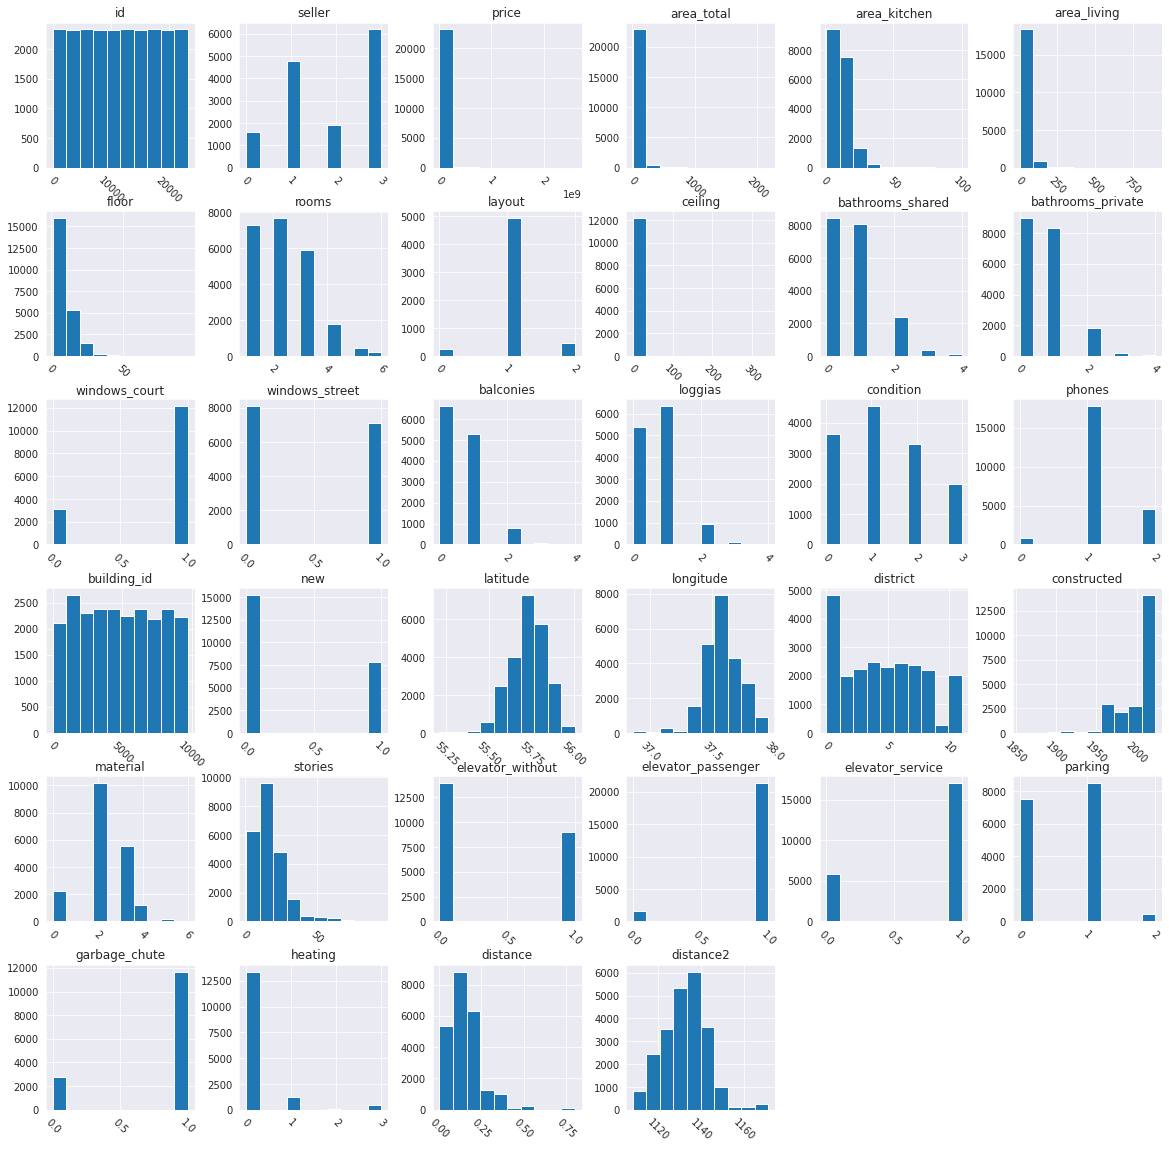

In [ ]:
data.hist(figsize=(20,20), xrot=-45)
sns.histplot(np.log10(data['price']))

In [ ]:
#model1 = LogisticRegression(random_state = 0).fit(X_train, y_train)
#model1.fit(X_train, y_train)
##y_train_hat = model1.predict(X_train)
#model1.predict_proba
#model1.predict_proba(X_valid)
##y_valid_hat = model1.predict(X_valid)
##print(f'Train RMSLE: {root_mean_squared_log_error(y_true=y_train, y_pred=y_train_hat) :.4f}')
##print(f'Valid RMSLE: {root_mean_squared_log_error(y_true=y_valid, y_pred=y_valid_hat) :.4f}')

# Implemented logisticregression, but the results were less than satisfactory

NameError: name 'LogisticRegression' is not defined

<AxesSubplot:>

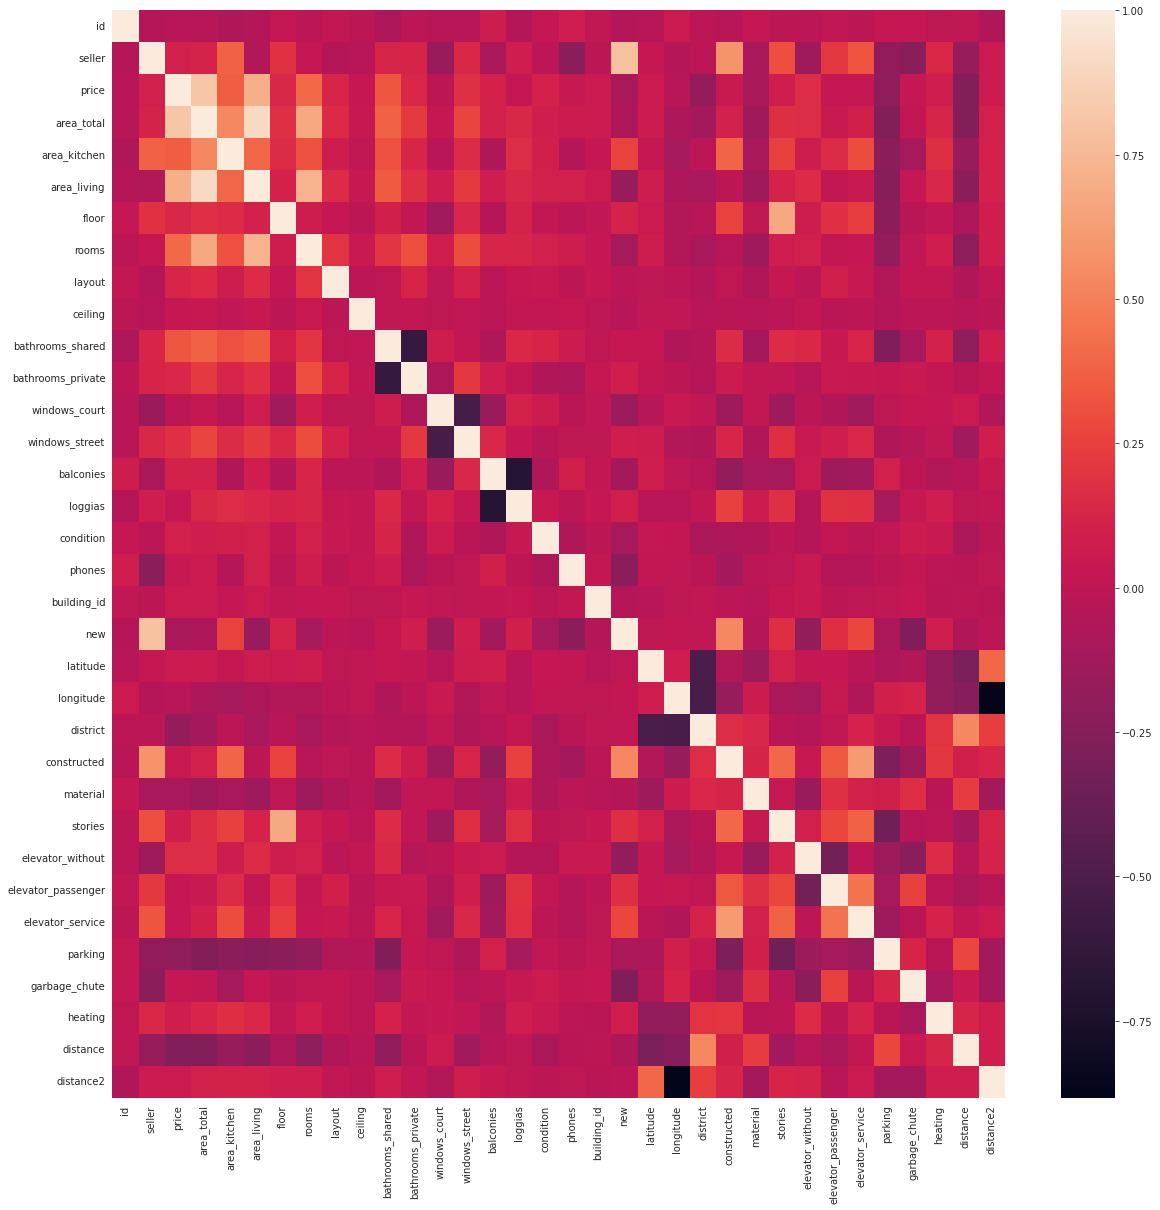

In [ ]:
# Explore the correlations in our data set 
plt.figure(figsize=(20,20))
sns.heatmap(data.corr())

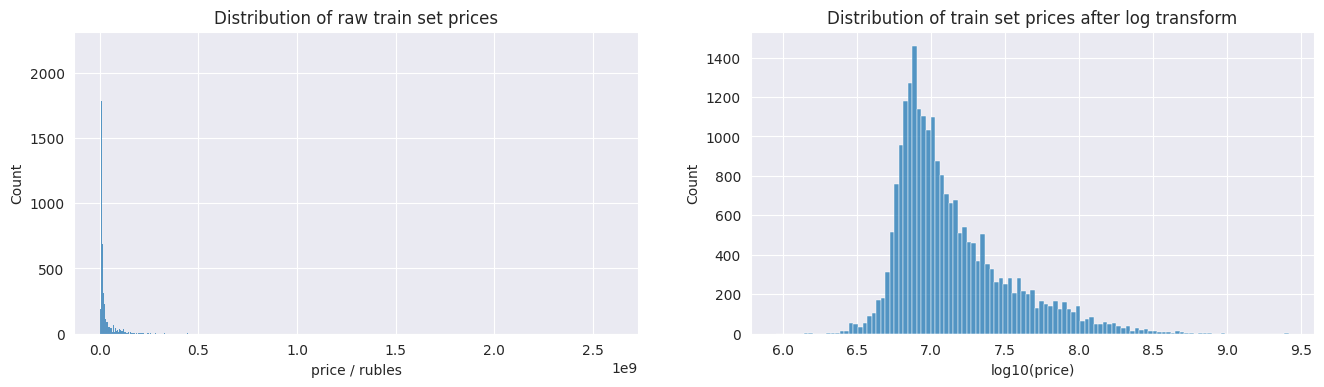

In [ ]:
fig, (ax1, ax2) = plt.subplots(figsize=(16, 4), ncols=2, dpi=100)
sns.histplot(data.price.rename('price / rubles'), ax=ax1)
ax1.set_title('Distribution of raw train set prices');
sns.histplot(np.log10(data.price).rename('log10(price)'), ax=ax2)
ax2.set_title('Distribution of train set prices after log transform');

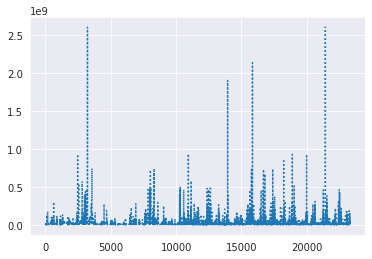

In [ ]:
plt.plot(data.price, linestyle = 'dotted')
plt.show()

<AxesSubplot:xlabel='rooms', ylabel='price'>

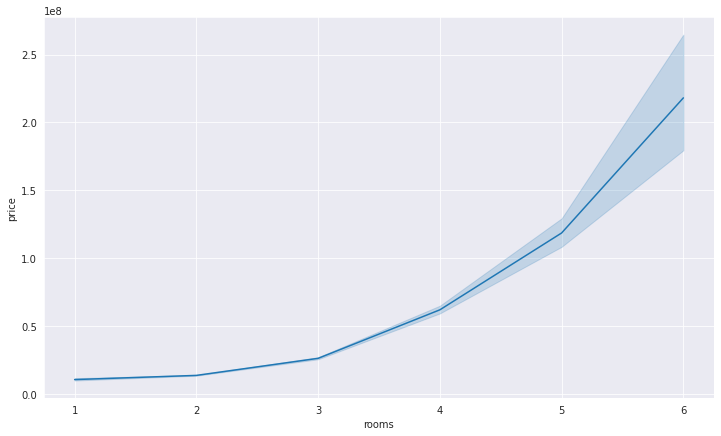

In [ ]:
plt.figure(figsize=(12,7))
sns.lineplot(x="rooms", y="price", data=data)

Number of missing price entries in train data: 0
Training set features with any missing value: 23/36


<AxesSubplot:title={'center':'Fraction of NaN values in the training set'}>

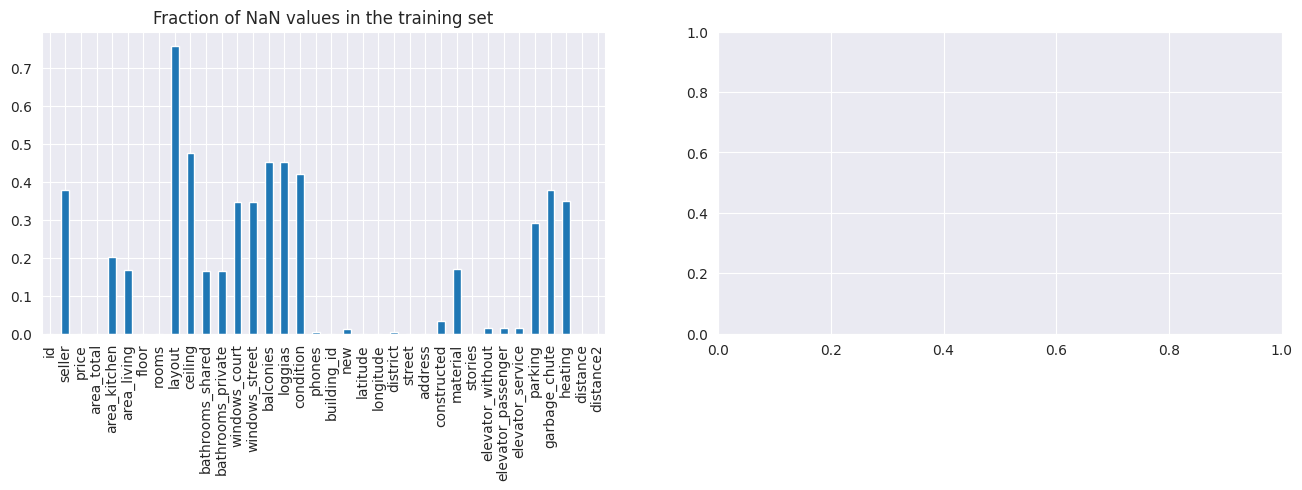

In [ ]:
fig, (ax1, ax2) = plt.subplots(figsize=(16, 4), ncols=2, dpi=100)
print(f'Number of missing price entries in train data: {data.price.isna().sum()}')
print(f'Training set features with any missing value: {data.isna().any().sum()}/{data.shape[1]}')
#print(f'Testing set features with any missing value: {data_test.isna().any().sum()}/{data_test.shape[1]}')
data.isna().mean().plot.bar(ax=ax1, title='Fraction of NaN values in the training set')
#data_test.isna().mean().plot.bar(ax=ax2, title='Fraction of NaN values in the testing set')

In [ ]:
def clean_data(data): #First attempt at cleaning data, based on discussion of assumptions. 
    nan_replacements = [
        # ('floor', 0), #no nans
        # ('rooms', 1), #no nans
        ('ceiling', data['ceiling'].mean()),
        #('bathrooms_shared',),
        #('bathrooms_private',),
        ('condition', 3),
        ('phones', 1),
        ('new', 0),
        #('contructed',),
        ('material', 2),
        ('elevator_without', 0),
        ('elevator_passenger', 1),
        ('elevator_service', 0),
        ('parking', 1),
        ('garbage_chute', 0),
        ('heating', 0),
        ('balconies', 0),
        ('loggias', 0),
        ('seller', 2),
        ('district', 2), #idk change
    ]

    data = data.drop(columns=["id", "area_total", "building_id",
        "street", "address", "stories", 'bathrooms_shared', 'bathrooms_private',
        'constructed', 'windows_street', 'windows_court', 'layout', 'area_kitchen', 'area_living' ])

    for feature, value in nan_replacements:
        data[feature] = data[feature].fillna(value)

    return data

data_ = clean_data(data)
print(data_.head())
data_train, data_valid = model_selection.train_test_split(data_, test_size=0.33, stratify=np.log(data_.price).round())


   id       price  area_total  floor  rooms  building_id   latitude  \
0   0   7139520.0        59.2    2.0    2.0         4076  55.544046   
1   1  10500000.0        88.0   18.0    3.0         1893  55.861282   
2   2   9019650.0        78.5   12.0    3.0         5176  55.663299   
3   3  10500000.0        88.0   18.0    3.0         1893  55.861282   
4   4  13900000.0        78.0    7.0    2.0         6604  55.590785   

   longitude             street address  stories  distance    distance2  
0  37.478055  Бунинские Луга ЖК  к2.5/2      9.0  0.239348  1130.590718  
1  37.666647     улица Радужная    14к3     25.0  0.129713  1133.804951  
2  37.515335  Саларьево Парк ЖК      38     15.0  0.121183  1133.769020  
3  37.666647     улица Радужная    14к3     25.0  0.129713  1133.804951  
4  37.451438   улица Сервантеса     1к3     15.0  0.217762  1134.383087  


In [ ]:
apartments_test = pd.read_csv('apartments_test.csv')
buildings_test = pd.read_csv('buildings_test.csv')
print(f'All test apartments have an associated building: {apartments_test.building_id.isin(buildings_test.id).all()}')
data_test = pd.merge(apartments_test, buildings_test.set_index('id'), how='left', left_on='building_id', right_index=True)
print(f'Number of train samples: {len(data)}')
print(f'Number of test samples:  {len(data_test)}')
data_test.head()


All test apartments have an associated building: True
Number of train samples: 23285
Number of test samples:  9937


,id,seller,area_total,area_kitchen,area_living,floor,rooms,layout,ceiling,bathrooms_shared,...,address,constructed,material,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,heating
0,23285,NaN,71.4,NaN,NaN,2.0,1.0,NaN,NaN,NaN,...,6к3,2017.0,2.0,20.0,1.0,1.0,1.0,NaN,1.0,0.0
1,23286,NaN,54.0,4.0,50.0,4.0,1.0,NaN,3.00,NaN,...,3к2,2017.0,2.0,15.0,0.0,1.0,1.0,0.0,0.0,0.0
2,23287,3.0,39.4,19.6,11.2,10.0,1.0,NaN,2.65,1.0,...,27,2021.0,3.0,9.0,0.0,1.0,1.0,1.0,NaN,NaN
3,23288,NaN,60.9,NaN,NaN,5.0,2.0,1.0,NaN,1.0,...,23,2014.0,2.0,17.0,1.0,1.0,0.0,NaN,1.0,3.0
4,23289,NaN,34.0,9.0,17.0,14.0,1.0,NaN,2.75,1.0,...,13к1,2016.0,2.0,17.0,0.0,1.0,1.0,NaN,1.0,0.0


In [ ]:
#data.describe()
#X_train = data_train.drop(columns=["id","area_total","floor", "rooms", "building_id", "street", "address", "stories"])
#X_valid = data_valid.drop(columns=["id", "area_total","floor", "rooms",  "building_id", "street", "address", "stories"])

#X_train = data_train.drop(columns=["id","latitude", "longitude", "street", "address"])
#X_valid = data_valid.drop(columns=["id","latitude", "longitude", "street", "address"])

X_train = data_train.drop(columns = ["id", "street", "address"])
X_valid = data_valid.drop(columns = ["id", "street", "address"])
#X_test = data_test.drop(columns = ["id", "street", "address"])
#y_test = data_test.price
print(len(X_train))
print(len(X_valid))
print(len(X_test))
y_train = data_train.price
y_valid = data_valid.price
#model1 = LogisticRegression(random_state = 0).fit(X_train, y_train)
#y_train_hat = model1.predict(X_train)
#y_valid_hat = model1.predict(X_valid)
#print(f'Train RMSLE: {root_mean_squared_log_error(y_true=y_train, y_pred=y_train_hat) :.4f}')
#print(f'Valid RMSLE: {root_mean_squared_log_error(y_true=y_train, y_pred=y_train_hat) :.4f}')

model = tree.DecisionTreeRegressor().fit(X_train, y_train)

y_train_hat = model.predict(X_train)
y_valid_hat = model.predict(X_valid)
#y_test_hat = model.predict(X_test)
"""
submission = pd.DataFrame()
submission['id'] = data_test.id
submission.loc[~X_test_nan, 'price_prediction'] = y_test_hat # Predict on non-nan entries
submission['price_prediction'].fillna(y_train.mean(), inplace=True) # Fill missing entries with mean predictor
print(f'Generated {len(submission)} predictions')

# Export submission to csv with headers
submission.to_csv('sample_submission.csv', index=False) """
print(f'Train RMSLE: {root_mean_squared_log_error(y_true=y_train, y_pred=y_train_hat) :.4f}')
print(f'Valid RMSLE: {root_mean_squared_log_error(y_true=y_valid, y_pred=y_valid_hat) :.4f}')
#print(f'Valid RMSLE: {root_mean_squared_log_error(y_true=y_test, y_pred=y_test_hat) :.4f}')


15600
7685


NameError: name 'X_test' is not defined

array([[<AxesSubplot:title={'center':'id'}>,
        <AxesSubplot:title={'center':'seller'}>,
        <AxesSubplot:title={'center':'price'}>,
        <AxesSubplot:title={'center':'area_total'}>,
        <AxesSubplot:title={'center':'area_kitchen'}>,
        <AxesSubplot:title={'center':'area_living'}>],
       [<AxesSubplot:title={'center':'floor'}>,
        <AxesSubplot:title={'center':'rooms'}>,
        <AxesSubplot:title={'center':'layout'}>,
        <AxesSubplot:title={'center':'ceiling'}>,
        <AxesSubplot:title={'center':'bathrooms_shared'}>,
        <AxesSubplot:title={'center':'bathrooms_private'}>],
       [<AxesSubplot:title={'center':'windows_court'}>,
        <AxesSubplot:title={'center':'windows_street'}>,
        <AxesSubplot:title={'center':'balconies'}>,
        <AxesSubplot:title={'center':'loggias'}>,
        <AxesSubplot:title={'center':'condition'}>,
        <AxesSubplot:title={'center':'phones'}>],
       [<AxesSubplot:title={'center':'building_id'}>,
        <

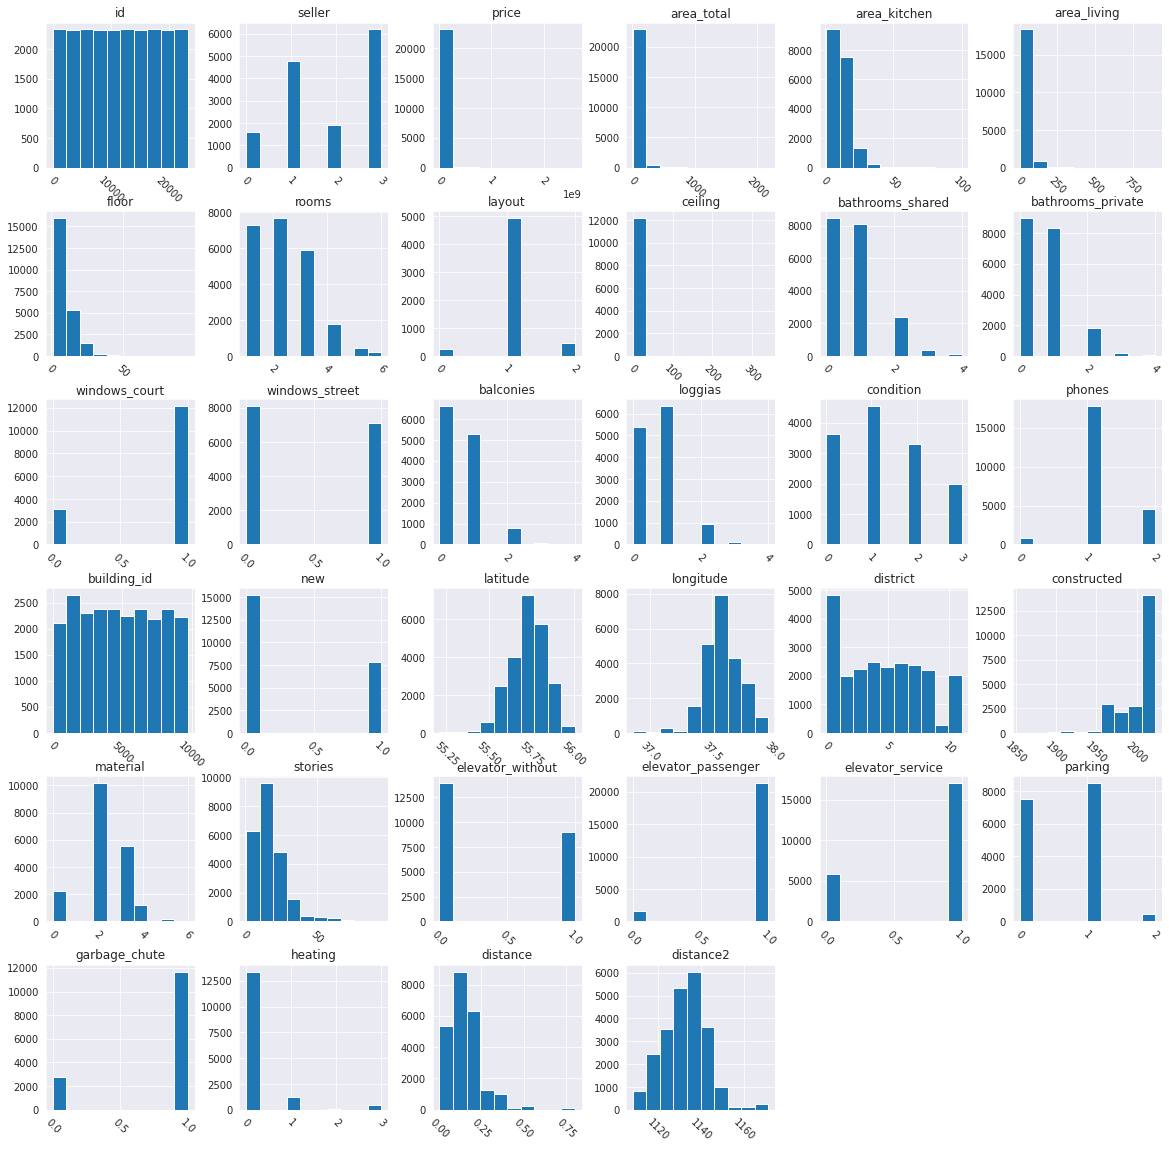

In [ ]:
#data.dtypes[data.dtypes!='object']
data.hist(figsize=(20,20), xrot=-45)

10645001.0

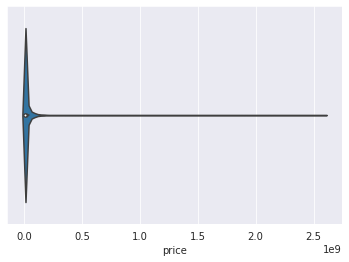

In [ ]:
sns.violinplot(data=data, x="price")
data.price.median() # Compare with median in Russia same year, same area

In [ ]:
data.select_dtypes(exclude=['object']).isnull().sum()

id                        0
seller                 8830
price                     0
area_total                0
area_kitchen           4721
area_living            3882
floor                     0
rooms                     0
layout                17642
ceiling               11093
bathrooms_shared       3872
bathrooms_private      3872
windows_court          8072
windows_street         8072
balconies             10520
loggias               10520
condition              9810
phones                   80
building_id               0
new                     264
latitude                  0
longitude                 0
district                130
constructed             794
material               3972
stories                   0
elevator_without        357
elevator_passenger      357
elevator_service        357
parking                6788
garbage_chute          8811
heating                8161
distance                  0
distance2                 0
dtype: int64

<ipython-input-19-1d8d0a2b2dfd>:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(data.corr(), dtype= np.bool)


<AxesSubplot:>

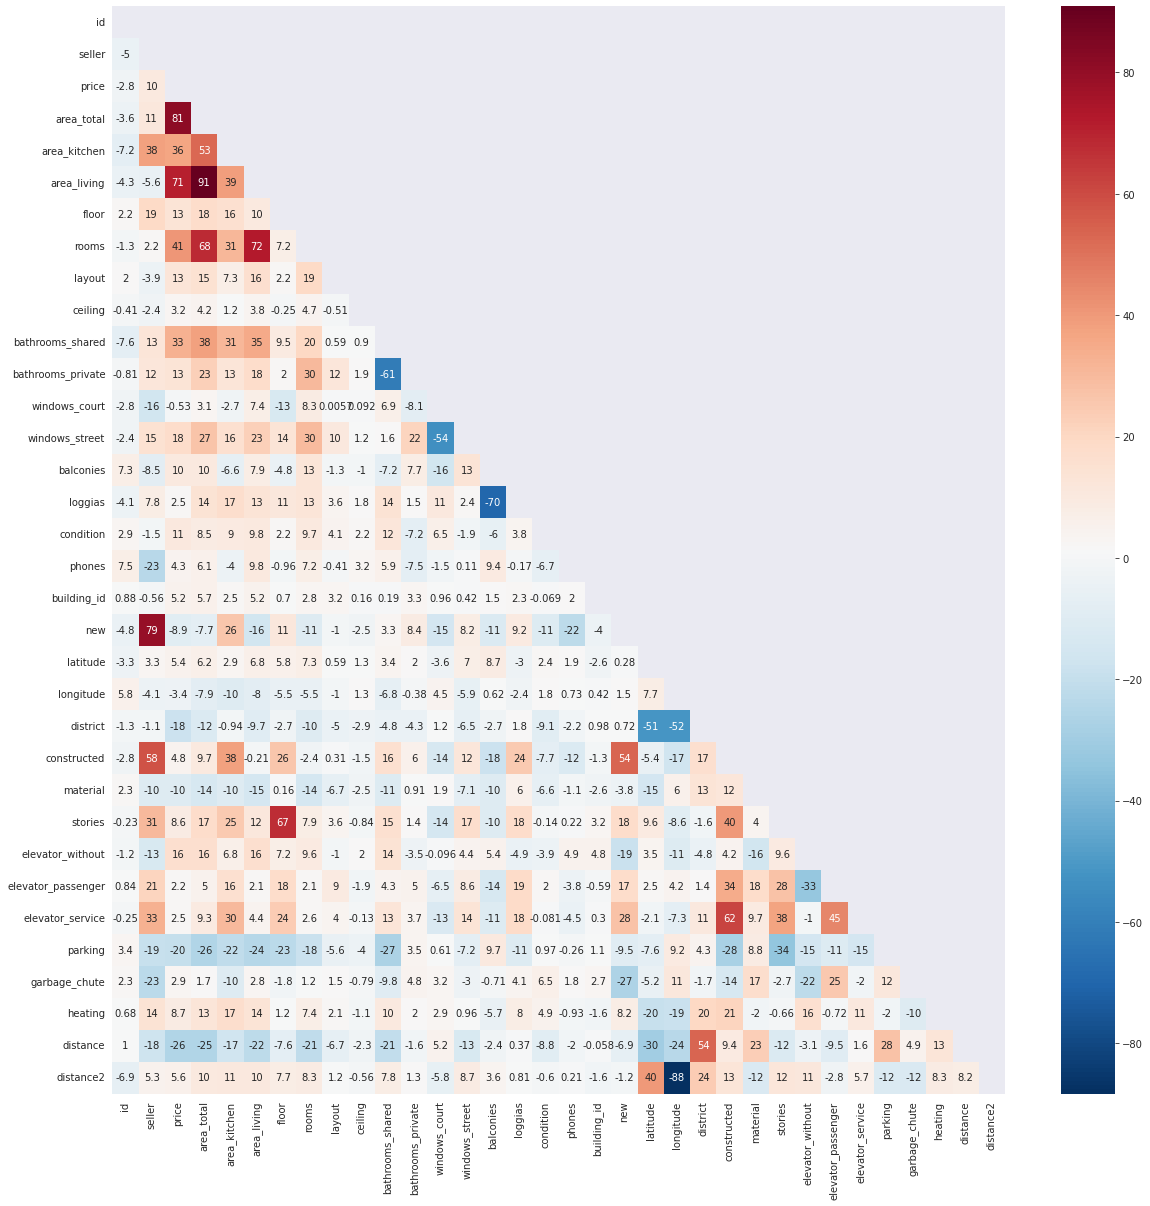

In [ ]:
# this diagram shows correlations between features, so we can determine what features to drop

mask = np.zeros_like(data.corr(), dtype= np.bool)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(data.corr()*100,cmap = 'RdBu_r', annot = True, mask = mask)

In [ ]:
# Random forest
from sklearn.ensemble import RandomForestRegressor
X_train = data_train.drop(columns = ["id", "street", "address"])
X_valid = data_valid.drop(columns = ["id", "street", "address"])
print(len(X_train))
print(len(X_valid))
y_train = data_train.price
y_valid = data_valid.price
#model1 = LogisticRegression(random_state = 0).fit(X_train, y_train)
#y_train_hat = model1.predict(X_train)
#y_valid_hat = model1.predict(X_valid)
#print(f'Train RMSLE: {root_mean_squared_log_error(y_true=y_train, y_pred=y_train_hat) :.4f}')
#print(f'Valid RMSLE: {root_mean_squared_log_error(y_true=y_train, y_pred=y_train_hat) :.4f}')

model = RandomForestRegressor(n_estimators=50).fit(X_train, y_train)

y_train_hat = model.predict(X_train)
y_valid_hat = model.predict(X_valid)
print(f'Train RMSLE: {root_mean_squared_log_error(y_true=y_train, y_pred=y_train_hat) :.4f}')
print(f'Valid RMSLE: {root_mean_squared_log_error(y_true=y_valid, y_pred=y_valid_hat) :.4f}')


#Once again not satisfactory results

NameError: name 'data_train' is not defined

In [ ]:
#Catboost
traindf = data.iloc[0:X_train.shape[0]].copy()
traindf.loc[:, "target"] = X_train.price
testdf = data.iloc[X_train.shape[0]::].copy()

In [ ]:
#catboost
from sklearn.model_selection import train_test_split
traindf, holddf = train_test_split(traindf, test_size=0.25, random_state=0)
print((traindf.shape, holddf.shape, testdf.shape))

((11700, 37), (3900, 37), (7685, 36))


In [ ]:
#hyperparameters
org_params = {
    'iterations': 10000,
    'learning_rate': 0.01,
    'eval_metric': 'RMSE',
    'random_seed': 42,
    'logging_level': 'Silent',
    'use_best_model': True,
    'loss_function': 'RMSE',
    'od_type': 'Iter',
    'od_wait': 1000,
    'one_hot_max_size': 20,
    'l2_leaf_reg': 100,
    'depth': 3,
    'rsm': 0.6,
    'random_strength': 2,
    'bagging_temperature': 10
}

In [ ]:
#fit model
from catboost import CatBoostRegressor
cat_model=CatBoostRegressor(**org_params)
cat_model.fit(X_train,y_train,
            eval_set=(X_valid,y_valid),
             use_best_model=True,
             plot=True);
#results = cat_model(traindf, 
                       #testdf,
                       #holddf,
                       #org_params,
                       #plot=True,
                       #n_splits=5,
                       #n_repeats=3)
#p_hold = results["p_hold"]
#p_test = results["p_test"]
#feature_importance_df = cat_model["feature_importance"]
y_train_hat = model.predict(X_train)
y_valid_hat = model.predict(X_valid)
print(f'Train RMSLE: {root_mean_squared_log_error(y_true=y_train, y_pred=y_train_hat) :.4f}')
print(f'Valid RMSLE: {root_mean_squared_log_error(y_true=y_valid, y_pred=y_valid_hat) :.4f}')

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

ImportError: No module named 'ipywidgets'

In [ ]:
"""list1 = []
for index, row in data.iterrows():
    px = 37.6 
    py = 55.75
    qx = row['longitude']
    qy = row['latitude']
    d = math.sqrt((px-qx)**2 + (py-qy)**2)
    list1.append(d)
data['distance'] = list1
print(data[['latitude', 'longitude', 'distance']].head())"""


df['distance'] = math.sqrt((37.6 - df['longitude'])**2 + (55.75 - df['latitude'])**2)

In [ ]:
# lightgb

In [ ]:
!pip install nbmerge


  Created wheel for nbmerge: filename=nbmerge-0.0.4-py2.py3-none-any.whl size=6413 sha256=4ef36d3499af2a83e6310e3a7d33eac3ff4f1ebb622f5ad403c8596b41d904d2
  Stored in directory: /root/.cache/pip/wheels/0b/a8/31/4ae563f674b488c82ee72cfe0f86487c21532db97ae910b264
Successfully built nbmerge
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [ ]:
!nbmerge long_notebook0.ipynb lightgb.ipynb short_notebook.ipynb > merged.ipynb

SyntaxError: invalid syntax (<ipython-input-6-748d2a009cd2>, line 1)

In [ ]:
!pip install -r requirements.txt

You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [ ]:
# Here we attempt to create a submission with catboost, on a csv we cleaned by replacing nan-values and dropping columns that seemed useless

data_train = pd.read_csv('Training_clean5.csv')
def root_mean_squared_log_error(y_true, y_pred):
    # Alternatively: sklearn.metrics.mean_squared_log_error(y_true, y_pred) ** 0.5
    assert (y_true >= 0).all() 
    assert (y_pred >= 0).all()
    log_error = np.log1p(y_pred) - np.log1p(y_true)  # Note: log1p(x) = log(1 + x)
    return np.mean(log_error ** 2) ** 0.5
data_test = pd.read_csv('Test_clean3.csv')

In [ ]:
# We considered replacing these features with their ratio, but found we got a better score without
#data_train['floor/stories'] = data_train.floor/data_train.stories
#data_test['floor/stories'] = data_test.floor/data_test.stories

# we use euclidian distance like before
data_train['distance'] = np.sqrt((37.6 - data_train['longitude'])**2 + (55.75 - data_train['latitude'])**2)
data_test['distance'] = np.sqrt((37.6 - data_test['longitude'])**2 + (55.75 - data_test['latitude'])**2)

#data_train.drop(['floor', 'stories', 'longitude', 'latitude'], axis=1, inplace=True)
data_train.drop(['longitude', 'latitude'], axis=1, inplace=True)
#data_test.drop(['floor', 'stories', 'longitude', 'latitude'], axis=1, inplace=True)
data_test.drop(['longitude', 'latitude'], axis=1, inplace=True)
data_train.head()


,id,seller,price,area_total,area_kitchen,area_living,floor,rooms,layout,ceiling,...,material,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,heating,street,distance
0,0,3,7139520.0,59.2,12.5,31.0,2,2,1,3,...,3,9,0,1,1,1,1,0,Бунинские Луга ЖК,0.239348
1,1,0,10500000.0,88.0,14.2,48.0,18,3,1,3,...,3,25,0,1,1,1,1,0,улица Радужная,0.129713
2,2,3,9019650.0,78.5,22.5,40.8,12,3,1,3,...,3,15,0,1,1,1,0,0,Саларьево Парк ЖК,0.121183
3,3,0,10500000.0,88.0,14.0,48.0,18,3,1,3,...,3,25,0,1,1,1,1,0,улица Радужная,0.129713
4,4,1,13900000.0,78.0,17.0,35.0,7,2,1,3,...,2,15,0,1,1,1,0,0,улица Сервантеса,0.217762


In [ ]:
data_test.head()

,id,seller,area_total,area_kitchen,area_living,floor,rooms,layout,ceiling,bathrooms_shared,...,material,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,heating,street,distance
0,23285,3,71.4,13.16,29.44,2,1,1,3,1,...,2,20,1,1,1,1,1,0,2-я Черногрязская улица,0.052411
1,23286,1,54.0,4.00,50.00,4,1,1,3,1,...,2,15,0,1,1,0,0,0,улица Сервантеса,0.216436
2,23287,3,39.4,19.60,11.20,10,1,1,3,1,...,3,9,0,1,1,1,1,0,Саларьево Парк ЖК,0.228879
3,23288,3,60.9,15.68,55.56,5,2,1,3,1,...,2,17,1,1,0,0,1,3,улица Александры Монаховой,0.217394
4,23289,3,34.0,9.00,17.00,14,1,1,3,1,...,2,17,0,1,1,1,1,0,улица 3-я Нововатутинская,0.345584


In [ ]:
target_train = data_train.price/data_train.area_total # Makes much more sense to predict price/sqm as this is used for benchmarking in economics. Domain knowledge
# Also tried to understand the russian housing market based on: https://tradingeconomics.com/russia/housing-index#:~:text=Housing%20Index%20in%20Russia%20averaged,the%20fourth%20quarter%20of%202009.&text=Russia%20House%20Price%20Index%20YoY%20%2D%20values%2C%20historical%20data%20and%20charts,updated%20on%20November%20of%202021
y_train_area_total = data_train.area_total
y_test_area_total = data_test.area_total
data_train.drop(['price', 'area_total'], axis=1, inplace=True)
data_train.head()
data_test.drop(['area_total'], axis=1, inplace=True)


NameError: name 'data_train' is not defined

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

ord_enc = OrdinalEncoder()
data_train['street'] = ord_enc.fit_transform(data_train[["street"]]).astype(int)
data_train.head()

,id,seller,area_kitchen,area_living,floor,rooms,layout,ceiling,bathrooms_shared,bathrooms_private,...,material,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,heating,street,distance
0,0,3,12.5,31.0,2,2,1,3,0,2,...,3,9,0,1,1,1,1,0,267,0.239348
1,1,0,14.2,48.0,18,3,1,3,2,0,...,3,25,0,1,1,1,1,0,1561,0.129713
2,2,3,22.5,40.8,12,3,1,3,0,2,...,3,15,0,1,1,1,0,0,774,0.121183
3,3,0,14.0,48.0,18,3,1,3,0,2,...,3,25,0,1,1,1,1,0,1561,0.129713
4,4,1,17.0,35.0,7,2,1,3,1,0,...,2,15,0,1,1,1,0,0,1589,0.217762


In [ ]:
import lightgbm

In [ ]:
# We create a split -> training data and validation data
X_train1, X_val1, y_train, y_val = train_test_split(data_train, target_train, test_size = 0.2, random_state=42)

X_train1.shape, X_val1.shape, y_train.shape, y_val.shape
X_train = X_train1.drop(['id'], axis=1)
X_val = X_val1.drop(['id'], axis=1)

In [ ]:


#cat_feature
#cat_feature_indices = np.array([ 3,6,10,15,16,20,21,24,25])

In [ ]:
train_data = lightgbm.Dataset(X_train, label = y_train)
test_data = lightgbm.Dataset(X_val, label = y_val)

In [ ]:
hyper_params = {
    'task': 'train',
    'boosting_type': 'dart',
    'objective': 'regression',
    'metric': ['l1','l2'],
    'learning_rate': 0.05,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 10,
    'verbose': 0,
    "max_depth": 8,
    "num_leaves": 128,  
    "max_bin": 512,
    "num_iterations": 10000
}

In [ ]:
gbm = lightgbm.LGBMRegressor(**hyper_params)

In [ ]:
X_train.drop(['layout', 'ceiling', 'windows_court', 'new','elevator_passenger', 'elevator_service', 'garbage_chute', 'heating'], axis=1, inplace=True)
# Feature dropping based on feature importance analysis further down

In [ ]:
X_val.drop(['layout', 'ceiling', 'windows_court', 'new','elevator_passenger', 'elevator_service', 'garbage_chute', 'heating'], axis=1, inplace=True)

In [ ]:
gbm.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric='RMSE', early_stopping_rounds=1000)

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9487]	valid_0's rmse: 51611.6	valid_0's l1: 25231.9	valid_0's l2: 2.66376e+09
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9488]	valid_0's rmse: 51612.8	valid_0's l1: 25232.4	valid_0's l2: 2.66388e+09
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9489]	valid_0's rmse: 51614	valid_0's l1: 25233.9	valid_0's l2: 2.664e+09
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9490]	valid_0's rmse: 51611.4	valid_0's l1: 25234.5	valid_0's l2: 2.66373e+09
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9491]	valid_0's rmse: 51608.5	valid_0's l1: 25232.8	valid_0's l2: 2.66344e+09
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9492]	valid_0's rmse: 51609.5	valid_0's l1: 25234.3	valid_0's l2: 2.66354e+09
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9493

LGBMRegressor(bagging_fraction=0.8, bagging_freq=10, boosting_type='dart',
              feature_fraction=0.8, learning_rate=0.05, max_bin=512,
              max_depth=8, metric=['l1', 'l2'], num_iterations=10000,
              num_leaves=128, objective='regression', task='train', verbose=0)

In [ ]:
y_pred = gbm.predict(X_train, num_iteration=gbm.best_iteration_)

In [ ]:
from sklearn.metrics import mean_squared_log_error 

In [ ]:
# Basic RMSE
print('The rmse of prediction is:', round(mean_squared_log_error(y_pred, y_train) ** 0.5, 5))

y_val_pred = gbm.predict(X_val, num_iteration=gbm.best_iteration_)
print('The rmse of prediction is:', round(mean_squared_log_error(y_val_pred, y_val) ** 0.5, 5))

#The rmse of prediction is: 0.01839
#The rmse of prediction is: 0.15097

The rmse of prediction is: 0.02946
The rmse of prediction is: 0.13968


In [ ]:

data_test['street'] = ord_enc.fit_transform(data_test[["street"]]).astype(int)
data_test.head()
#data_test


,id,seller,area_kitchen,area_living,floor,rooms,layout,ceiling,bathrooms_shared,bathrooms_private,...,material,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,heating,street,distance
0,23285,3,13.16,29.44,2,1,1,3,1,1,...,2,20,1,1,1,1,1,0,50,0.052411
1,23286,1,4.00,50.00,4,1,1,3,1,1,...,2,15,0,1,1,0,0,0,1112,0.216436
2,23287,3,19.60,11.20,10,1,1,3,1,0,...,3,9,0,1,1,1,1,0,547,0.228879
3,23288,3,15.68,55.56,5,2,1,3,1,0,...,2,17,1,1,0,0,1,3,856,0.217394
4,23289,3,9.00,17.00,14,1,1,3,1,0,...,2,17,0,1,1,1,1,0,818,0.345584


In [ ]:
data_test1 = data_test.drop(["id",'layout', 'ceiling', 'windows_court', 'new','elevator_passenger', 'elevator_service', 'garbage_chute', 'heating'],axis=1)
print(data_test1)
y_test_pred = gbm.predict(data_test1, num_iteration = gbm.best_iteration_)

      seller  area_kitchen  area_living  floor  rooms  bathrooms_shared  \
0          3         13.16        29.44      2      1                 1   
1          1          4.00        50.00      4      1                 1   
2          3         19.60        11.20     10      1                 1   
3          3         15.68        55.56      5      2                 1   
4          3          9.00        17.00     14      1                 1   
...      ...           ...          ...    ...    ...               ...   
9932       3         19.90        56.70     16      3                 1   
9933       1          8.88        33.22      3      3                 2   
9934       1         22.06        78.22     15      1                 1   
9935       1         10.50        15.10     14      1                 1   
9936       1          7.00        49.00      2      3                 0   

      bathrooms_private  windows_street  balconies  loggias  ...  phones  \
0                     1

In [ ]:
final_labels = y_test_pred * y_test_area_total
final_labels.head()

0    2.814662e+07
1    1.179517e+07
2    6.097245e+06
3    9.359757e+06
4    5.126253e+06
Name: area_total, dtype: float64

In [ ]:
submission = pd.DataFrame()
submission['id'] = data_test.id
submission['price_prediction'] = final_labels # Predict on non-nan entries
 # Fill missing entries with mean predictor
print(f'Generated {len(submission)} predictions')

# Export submission to csv with headers
#submission.to_csv('sample_submission.csv', index=False)

submission.to_csv('sample_submission17.csv', index=False)

Generated 9937 predictions


In [ ]:
gbm.booster_.feature_importance() # Feature importance as a way of model interpretation
fea_imp_ = pd.DataFrame({'cols':X_train.columns, 'fea_imp':gbm.feature_importances_})
fea_imp_.loc[fea_imp_.fea_imp > 0].sort_values(by=['fea_imp'], ascending = False)

,cols,fea_imp
20,distance,139107
2,area_living,115698
12,building_id,94181
1,area_kitchen,91902
14,constructed,91826
19,street,80956
16,stories,74534
3,floor,67646
13,district,46946
10,condition,29160


In [ ]:
# !pip install -r requirements.txt

!pip install xgboost
!pip install catboost
!pip install ipywidgets
!pip install LightGBM

You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [ ]:
import json
import pandas as pd
import numpy as np
import math as math
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.model_selection as model_selection
import sklearn.tree as tree
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
import time
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
import catboost
from catboost import CatBoostRegressor
from sklearn.impute import KNNImputer




In [ ]:
apartments_train = pd.read_csv('apartments_train.csv')
apartments_test = pd.read_csv('apartments_test.csv')
with open('apartments_meta.json') as f: 
    apartments_meta = json.load(f)

buildings_train = pd.read_csv('buildings_train.csv')
buildings_test = pd.read_csv('buildings_test.csv')
with open('buildings_meta.json') as f: 
    buildings_meta = json.load(f)
#print(f'All apartments have an associated building: {apartments.building_id.isin(buildings.id).all()}')
df = pd.merge(apartments_train, buildings_train.set_index('id'), how='left', left_on='building_id', right_index=True)
df_test = pd.merge(apartments_test, buildings_test.set_index('id'), how='left', left_on='building_id', right_index=True)
df.head()
df['street'].isnull().sum()

0

In [ ]:
df.isnull().sum()

id                        0
seller                 8830
price                     0
area_total                0
area_kitchen           4721
area_living            3882
floor                     0
rooms                     0
layout                17642
ceiling               11093
bathrooms_shared       3872
bathrooms_private      3872
windows_court          8072
windows_street         8072
balconies             10520
loggias               10520
condition              9810
phones                   80
building_id               0
new                     264
latitude                  0
longitude                 0
district                130
street                    0
address                   0
constructed             794
material               3972
stories                   0
elevator_without        357
elevator_passenger      357
elevator_service        357
parking                6788
garbage_chute          8811
heating                8161
dtype: int64

<AxesSubplot:>

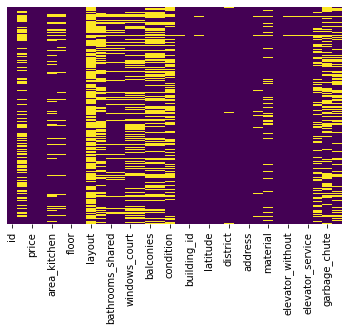

In [ ]:
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis')

In [ ]:
df.shape


(23285, 34)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23285 entries, 0 to 23284
Data columns (total 34 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  23285 non-null  int64  
 1   seller              14455 non-null  float64
 2   price               23285 non-null  float64
 3   area_total          23285 non-null  float64
 4   area_kitchen        18564 non-null  float64
 5   area_living         19403 non-null  float64
 6   floor               23285 non-null  float64
 7   rooms               23285 non-null  float64
 8   layout              5643 non-null   float64
 9   ceiling             12192 non-null  float64
 10  bathrooms_shared    19413 non-null  float64
 11  bathrooms_private   19413 non-null  float64
 12  windows_court       15213 non-null  float64
 13  windows_street      15213 non-null  float64
 14  balconies           12765 non-null  float64
 15  loggias             12765 non-null  float64
 16  cond

In [ ]:
df['price/area'] = df['price']/df['area_total']

# The center of Moscow is at longitude: 37.6 and latitude: 55.75
df['distance'] = np.sqrt((37.6 - df['longitude'])**2 + (55.75 - df['latitude'])**2)
df_test['distance'] = np.sqrt((37.6 - df_test['longitude'])**2 + (55.75 - df_test['latitude'])**2)

df.drop(['longitude', 'latitude'], axis=1, inplace=True)
df_test.drop(['longitude', 'latitude'], axis=1, inplace=True)

In [ ]:
df2 = df[['id', 'price/area', 'distance']]
mintreshold, maxtreshold = df2['price/area'].quantile([0.001, 0.999])
df[df2['price/area'] < mintreshold]

,id,seller,price,area_total,area_kitchen,area_living,floor,rooms,layout,ceiling,...,material,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,heating,price/area,distance
2215,2215,NaN,1900000.0,55.8,NaN,35.0,1.0,1.0,NaN,NaN,...,2.0,5.0,0.0,1.0,1.0,1.0,0.0,NaN,34050.179211,0.495102
2236,2236,1.0,3000000.0,60.0,8.0,45.0,3.0,3.0,1.0,NaN,...,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,50000.000000,0.753930
2241,2241,1.0,3500000.0,75.0,12.0,41.0,2.0,3.0,1.0,NaN,...,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,46666.666667,0.245644
2363,2363,2.0,7999999.0,343.0,NaN,222.0,2.0,6.0,NaN,NaN,...,2.0,25.0,1.0,1.0,1.0,1.0,1.0,0.0,23323.612245,0.128081
7512,7512,1.0,2950000.0,60.0,8.3,34.0,4.0,2.0,1.0,NaN,...,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,49166.666667,0.753930
7513,7513,1.0,3000000.0,60.3,9.0,48.0,4.0,2.0,1.0,NaN,...,NaN,4.0,1.0,0.0,0.0,1.0,NaN,NaN,49751.243781,0.755084
7514,7514,1.0,3350000.0,75.0,12.0,41.0,5.0,3.0,1.0,NaN,...,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,44666.666667,0.748937
7572,7572,0.0,1000000.0,21.0,4.0,14.0,1.0,1.0,NaN,NaN,...,2.0,4.0,1.0,0.0,0.0,1.0,NaN,0.0,47619.047619,0.254783
11167,11167,1.0,13750000.0,271.0,25.0,150.0,4.0,6.0,1.0,NaN,...,4.0,5.0,1.0,0.0,0.0,NaN,NaN,0.0,50738.007380,0.131647
13201,13201,1.0,2900000.0,60.0,NaN,60.0,1.0,1.0,NaN,NaN,...,2.0,3.0,1.0,0.0,0.0,1.0,0.0,1.0,48333.333333,0.238612


In [ ]:
a = list(df[df2['price/area'] > maxtreshold].id.values)
b = list(df[df2['price/area'] < mintreshold].id.values)
c = a + b

In [ ]:
a = df.shape
df.drop(c, axis=0, inplace=True)
b = df.shape
a,b

((23285, 34), (23237, 34))

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23237 entries, 0 to 23284
Data columns (total 34 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  23237 non-null  int64  
 1   seller              14435 non-null  float64
 2   price               23237 non-null  float64
 3   area_total          23237 non-null  float64
 4   area_kitchen        18538 non-null  float64
 5   area_living         19372 non-null  float64
 6   floor               23237 non-null  float64
 7   rooms               23237 non-null  float64
 8   layout              5626 non-null   float64
 9   ceiling             12181 non-null  float64
 10  bathrooms_shared    19378 non-null  float64
 11  bathrooms_private   19378 non-null  float64
 12  windows_court       15188 non-null  float64
 13  windows_street      15188 non-null  float64
 14  balconies           12745 non-null  float64
 15  loggias             12745 non-null  float64
 16  cond

In [ ]:
df['street'].isnull().sum()

0

In [ ]:
df0 = df.drop(['street', 'address'], axis=1)
df0_test = df_test.drop(['street', 'address'], axis=1)

df0.columns

Index(['id', 'seller', 'price', 'area_total', 'area_kitchen', 'area_living',
       'floor', 'rooms', 'layout', 'ceiling', 'bathrooms_shared',
       'bathrooms_private', 'windows_court', 'windows_street', 'balconies',
       'loggias', 'condition', 'phones', 'building_id', 'new', 'district',
       'constructed', 'material', 'stories', 'elevator_without',
       'elevator_passenger', 'elevator_service', 'parking', 'garbage_chute',
       'heating', 'price/area', 'distance'],
      dtype='object')

In [ ]:
import sys
# 'seller', 'layout', 'ceiling', 'balconies', 'loggias', 'condition', 'garbage_chute', 'heating'

#sys.setrecursionlimit(100000) #Increase the recursion limit of the OS

# start the KNN training
imputer = KNNImputer()
imputer.fit(df0)
dftrans = imputer.transform(df0)

imputer.fit(df0_test)
dftrans_test = imputer.transform(df0_test)


In [ ]:
"""
df = df.drop(['seller', 'layout', 'ceiling', 'balconies', 'loggias', 'condition', 'garbage_chute', 'heating'], axis=1)

df.area_kitchen.fillna(df.area_total *0.20382557322076747, inplace=True)
df.area_living.fillna(df.area_total *0.5489437954371277, inplace=True)
df.bathrooms_shared.fillna(df.bathrooms_shared.mode()[0], inplace = True)
df.bathrooms_private.fillna(df.bathrooms_private.mode()[0], inplace = True)
df.windows_court.fillna(df.windows_court.mode()[0], inplace = True)
df.windows_street.fillna(df.windows_street.mode()[0], inplace = True)
df.phones.fillna(df.phones.mode()[0], inplace=True)
df.new.fillna(df.new.mode()[0], inplace = True)
df.latitude.fillna(df.latitude.mean(), inplace = True)
df.longitude.fillna(df.longitude.mean(), inplace = True)
df.district.fillna(df.district.mode()[0], inplace = True)
df.constructed.fillna(df.constructed.mode()[0], inplace = True)
df.material.fillna(df.material.mode()[0], inplace = True)
df.elevator_without.fillna(df.elevator_without.mode()[0], inplace = True)
df.elevator_passenger.fillna(df.elevator_passenger.mode()[0], inplace = True)
df.elevator_service.fillna(df.elevator_service.mode()[0], inplace = True)
df.parking.fillna(df.parking.mode()[0], inplace = True)
df.shape
df.isnull().sum()
"""

"\ndf = df.drop(['seller', 'layout', 'ceiling', 'balconies', 'loggias', 'condition', 'garbage_chute', 'heating'], axis=1)\n\ndf.area_kitchen.fillna(df.area_total *0.20382557322076747, inplace=True)\ndf.area_living.fillna(df.area_total *0.5489437954371277, inplace=True)\ndf.bathrooms_shared.fillna(df.bathrooms_shared.mode()[0], inplace = True)\ndf.bathrooms_private.fillna(df.bathrooms_private.mode()[0], inplace = True)\ndf.windows_court.fillna(df.windows_court.mode()[0], inplace = True)\ndf.windows_street.fillna(df.windows_street.mode()[0], inplace = True)\ndf.phones.fillna(df.phones.mode()[0], inplace=True)\ndf.new.fillna(df.new.mode()[0], inplace = True)\ndf.latitude.fillna(df.latitude.mean(), inplace = True)\ndf.longitude.fillna(df.longitude.mean(), inplace = True)\ndf.district.fillna(df.district.mode()[0], inplace = True)\ndf.constructed.fillna(df.constructed.mode()[0], inplace = True)\ndf.material.fillna(df.material.mode()[0], inplace = True)\ndf.elevator_without.fillna(df.elevator

In [ ]:
"""df.elevator_without = df.elevator_without.astype(int)
df.floor = df.floor.astype(int)
df.rooms = df.rooms.astype(int)
df.bathrooms_shared = df.bathrooms_shared.astype(int)
df.bathrooms_private = df.bathrooms_private.astype(int)
df.windows_court = df.windows_court.astype(int)
df.windows_street = df.windows_street.astype(int)
df.phones = df.phones.astype(int)
df.new = df.new.astype(int)
df.district = df.district.astype(int)
df.constructed = df.constructed.astype(int)
df.material = df.material.astype(int)
df.stories = df.stories.astype(int)
df.elevator_without = df.elevator_without.astype(int)
df.elevator_passenger = df.elevator_passenger.astype(int)
df.elevator_service = df.elevator_service.astype(int)
df.parking = df.parking.astype(int)
"""

'df.elevator_without = df.elevator_without.astype(int)\ndf.floor = df.floor.astype(int)\ndf.rooms = df.rooms.astype(int)\ndf.bathrooms_shared = df.bathrooms_shared.astype(int)\ndf.bathrooms_private = df.bathrooms_private.astype(int)\ndf.windows_court = df.windows_court.astype(int)\ndf.windows_street = df.windows_street.astype(int)\ndf.phones = df.phones.astype(int)\ndf.new = df.new.astype(int)\ndf.district = df.district.astype(int)\ndf.constructed = df.constructed.astype(int)\ndf.material = df.material.astype(int)\ndf.stories = df.stories.astype(int)\ndf.elevator_without = df.elevator_without.astype(int)\ndf.elevator_passenger = df.elevator_passenger.astype(int)\ndf.elevator_service = df.elevator_service.astype(int)\ndf.parking = df.parking.astype(int)\n'

In [ ]:
df1 = pd.DataFrame(dftrans, columns=list(df0.columns.values))
df1_test = pd.DataFrame(dftrans_test, columns=list(df0_test.columns.values))
df1.isnull().sum()
df1.shape
len(df.street)

23237

In [ ]:
"""df1.elevator_without = df1.elevator_without.astype(int)
df1.floor = df1.floor.astype(int)
df1.rooms = df1.rooms.astype(int)
df1.bathrooms_shared = df1.bathrooms_shared.astype(int)
df1.bathrooms_private = df1.bathrooms_private.astype(int)
df1.windows_court = df1.windows_court.astype(int)
df1.windows_street = df1.windows_street.astype(int)
df1.phones = df1.phones.astype(int)
df1.new = df1.new.astype(int)
df1.district = df1.district.astype(int)
df1.constructed = df1.constructed.astype(int)
df1.material = df1.material.astype(int)
df1.stories = df1.stories.astype(int)
df1.elevator_without = df1.elevator_without.astype(int)
df1.elevator_passenger = df1.elevator_passenger.astype(int)
df1.elevator_service = df1.elevator_service.astype(int)
df1.parking = df1.parking.astype(int)
df1.garbage_chute = df1.garbage_chute.astype(int)
df1.heating = df1.heating.astype(int)
df1.building_id = df1.building_id.astype(int)
df1.condition = df1.condition.astype(int)
df1.loggias = df1.loggias.astype(int)
df1.balconies = df1.balconies.astype(int)
#df1.ceiling = df1.ceiling.round(0)
#df1.ceiling = df1.ceiling.astype(int)"""




'df1.elevator_without = df1.elevator_without.astype(int)\ndf1.floor = df1.floor.astype(int)\ndf1.rooms = df1.rooms.astype(int)\ndf1.bathrooms_shared = df1.bathrooms_shared.astype(int)\ndf1.bathrooms_private = df1.bathrooms_private.astype(int)\ndf1.windows_court = df1.windows_court.astype(int)\ndf1.windows_street = df1.windows_street.astype(int)\ndf1.phones = df1.phones.astype(int)\ndf1.new = df1.new.astype(int)\ndf1.district = df1.district.astype(int)\ndf1.constructed = df1.constructed.astype(int)\ndf1.material = df1.material.astype(int)\ndf1.stories = df1.stories.astype(int)\ndf1.elevator_without = df1.elevator_without.astype(int)\ndf1.elevator_passenger = df1.elevator_passenger.astype(int)\ndf1.elevator_service = df1.elevator_service.astype(int)\ndf1.parking = df1.parking.astype(int)\ndf1.garbage_chute = df1.garbage_chute.astype(int)\ndf1.heating = df1.heating.astype(int)\ndf1.building_id = df1.building_id.astype(int)\ndf1.condition = df1.condition.astype(int)\ndf1.loggias = df1.logg

In [ ]:
df1.head()

,id,seller,price,area_total,area_kitchen,area_living,floor,rooms,layout,ceiling,...,material,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,heating,price/area,distance
0,0.0,3.0,7139520.0,59.2,12.5,31.0,2.0,2.0,0.8,2.650,...,3.0,9.0,0.0,1.0,1.0,1.0,0.8,0.2,120600.000000,0.239348
1,1.0,1.2,10500000.0,88.0,14.2,48.0,18.0,3.0,1.0,2.652,...,3.0,25.0,0.0,1.0,1.0,1.0,1.0,0.0,119318.181818,0.129713
2,2.0,3.0,9019650.0,78.5,22.5,40.8,12.0,3.0,1.0,2.650,...,3.0,15.0,0.0,1.0,1.0,1.0,0.8,0.2,114900.000000,0.121183
3,3.0,1.2,10500000.0,88.0,14.0,48.0,18.0,3.0,1.0,2.652,...,3.0,25.0,0.0,1.0,1.0,1.0,1.0,0.0,119318.181818,0.129713
4,4.0,1.8,13900000.0,78.0,17.0,35.0,7.0,2.0,1.0,2.900,...,2.0,15.0,0.0,1.0,1.0,1.0,0.0,0.0,178205.128205,0.217762


In [ ]:
# categorical features and integers that must be rounded and cast to int

names = ['seller', 'floor', 'rooms', 'layout', 'ceiling', 
'bathrooms_shared', 'bathrooms_private', 'windows_court', 'windows_street', 'balconies', 'loggias', 'condition', 
'phones', 'building_id', 'new', 'district', 'constructed', 'material', 'stories', 'elevator_without', 
'elevator_passenger', 'elevator_service', 'parking', 'garbage_chute', 'heating']
#print(df.street.isnull().sum(),df1.street.isnull().sum())
for x in names:
    df1[x] = df1[x].round(decimals = 0)
    df1[x] = df1[x].astype(int)

    df1_test[x] = df1_test[x].round(decimals = 0)
    df1_test[x] = df1_test[x].astype(int)

#df1['street'].isnull().sum()
print(df1.shape, df.shape)

(23237, 32) (23237, 34)


In [ ]:

df1['id'] = df1['id'].astype(int)


df1 = pd.merge(df1, df[['id', 'street']], on='id')


df1_test['id'] = df1_test['id'].astype(int)
df1_test['street'] = df_test.street

#print(df1.shape, df.shape)
#df1.head()
#df1['street'].isnull().sum()
#df1.to_csv('Training_clean.csv', index=False)
#df1_test.to_csv('Test_clean.csv', index=False)

In [ ]:
df1.shape

(23237, 33)

In [ ]:
df1[df1.id==455]

,id,seller,price,area_total,area_kitchen,area_living,floor,rooms,layout,ceiling,...,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,heating,price/area,distance,street
455,455,3,32268200.0,101.45,14.32,78.16,1,3,1,3,...,18,0,1,1,0,1,0,318069.985214,0.11515,улица Маршала Рыбалко


In [ ]:
#df_train['floor/stories'] = df_train.floor/df_train.stories
#df_test['floor/stories'] = df_test.floor/df_test.stories

#df_train['distance'] = np.sqrt((37.6 - df_train['longitude'])**2 + (55.75 - df_train['latitude'])**2)
#df_test['distance'] = np.sqrt((37.6 - df_test['longitude'])**2 + (55.75 - df_test['latitude'])**2)
# happens further up

In [ ]:
df_train = df1
df_test = df1_test

In [ ]:
df_test.shape

(9937, 32)

In [ ]:
df_train.shape

(23237, 33)

In [ ]:
X1_test.head()

,area_total,area_kitchen,area_living,floor,rooms,layout,windows_court,windows_street,balconies,condition,...,district,street,address,stories,elevator_passenger,elevator_service,parking,garbage_chute,heating,distance
0,71.4,NaN,NaN,2.0,1.0,NaN,1.0,0.0,1.0,0.0,...,0.0,2-я Черногрязская улица,6к3,20.0,1.0,1.0,NaN,1.0,0.0,0.052411
1,54.0,4.0,50.0,4.0,1.0,NaN,1.0,0.0,NaN,3.0,...,11.0,улица Сервантеса,3к2,15.0,1.0,1.0,0.0,0.0,0.0,0.216436
2,39.4,19.6,11.2,10.0,1.0,NaN,1.0,0.0,NaN,NaN,...,11.0,Саларьево Парк ЖК,27,9.0,1.0,1.0,1.0,NaN,NaN,0.228879
3,60.9,NaN,NaN,5.0,2.0,1.0,0.0,1.0,NaN,0.0,...,11.0,улица Александры Монаховой,23,17.0,1.0,0.0,NaN,1.0,3.0,0.217394
4,34.0,9.0,17.0,14.0,1.0,NaN,1.0,0.0,0.0,1.0,...,11.0,улица 3-я Нововатутинская,13к1,17.0,1.0,1.0,NaN,1.0,0.0,0.345584


In [ ]:
#y1 = df_train['price']

X1_test = df_test.drop(['id', 'bathrooms_private', 'loggias', 'seller', 'bathrooms_shared', 'elevator_without', 'ceiling', 'material', 'constructed'], axis=1)

X1_test_area_total = X1_test.area_total.values # Save area total values from training set so that we can use feature engineering on price/area as measure
#df_train['price/area'] = df_train['price']/df_train['area_total'] #already done
y1 = df_train['price/area'] # Don't drop area here because we need it for split

X1 = df_train.drop(['price', 'id', 'price/area', 'bathrooms_private', 'loggias', 'seller', 'bathrooms_shared', 'elevator_without', 'ceiling', 'material', 'constructed'], axis=1)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X1, y1, test_size=0.2, random_state=1, shuffle=True)
X_train.shape, X_val.shape, y_train.shape,y_val.shape, X1_test.shape

((18589, 22), (4648, 22), (18589,), (4648,), (9937, 22))

In [ ]:
X1_test.head()

,area_total,area_kitchen,area_living,floor,rooms,layout,windows_court,windows_street,balconies,condition,...,new,district,stories,elevator_passenger,elevator_service,parking,garbage_chute,heating,distance,street
0,71.4,13.16,29.44,2,1,1,1,0,1,0,...,0,0,20,1,1,1,1,0,0.052411,2-я Черногрязская улица
1,54.0,4.00,50.00,4,1,1,1,0,0,3,...,0,11,15,1,1,0,0,0,0.216436,улица Сервантеса
2,39.4,19.60,11.20,10,1,1,1,0,0,2,...,1,11,9,1,1,1,1,0,0.228879,Саларьево Парк ЖК
3,60.9,15.68,55.56,5,2,1,0,1,0,0,...,0,11,17,1,0,0,1,3,0.217394,улица Александры Монаховой
4,34.0,9.00,17.00,14,1,1,1,0,0,1,...,0,11,17,1,1,1,1,0,0.345584,улица 3-я Нововатутинская


In [ ]:
area_total_train = X_train.area_total.values
area_total_val = X_val.area_total.values
X_train = X_train.drop(['area_total'], axis=1)
X_val = X_val.drop(['area_total'], axis=1)
X_train.head()

,area_kitchen,area_living,floor,rooms,layout,windows_court,windows_street,balconies,condition,phones,...,new,district,stories,elevator_passenger,elevator_service,parking,garbage_chute,heating,distance,street
8161,16.1,28.2,3,2,1,1,0,0,1,1,...,1,11,14,1,1,0,1,0,0.209419,Скандинавия ЖК
10138,7.8,15.7,10,1,1,1,0,1,0,1,...,0,4,17,1,1,1,1,0,0.349929,улица Вертолетчиков
4845,6.0,30.0,3,2,1,0,1,1,1,1,...,0,6,9,1,0,1,1,0,0.141238,улица Островитянова
7189,12.4,33.0,18,2,1,1,1,1,0,2,...,0,2,20,1,1,1,1,0,0.103533,Нововладыкинский проезд
14728,14.4,27.1,14,2,1,1,0,1,1,1,...,1,8,20,1,1,1,1,0,0.108437,3-я Хорошевская улица


In [ ]:
df_final = X1
df_final['price/area'] = y1.values

#df1.to_csv('Training_clean.csv', index=False)
#X1_test.to_csv('Test_clean.csv', index=False)


In [ ]:
categorical_features_indices = np.where(X_train.dtypes != np.float64)[0]


In [ ]:
def root_mean_squared_log_error(y_true, y_pred):
    # Alternatively: sklearn.metrics.mean_squared_log_error(y_true, y_pred) ** 0.5
    assert (y_true >= 0).all() 
    assert (y_pred >= 0).all()
    log_error = np.log1p(y_pred) - np.log1p(y_true)  # Note: log1p(x) = log(1 + x)
    return np.mean(log_error ** 2) ** 0.5

#df_train = df_final
#df_test = X1_test

In [ ]:
#hyper parameter
n_estimators=[100,500,900,1100,1500]
max_depth=[2,3,5,10,15]
booster=["gbtree","gblinear"]
learning_rate="[0.05,0.1,0.15,0.20]"
min_child_weight=[1,2,3,4]
base_score=[0.25,0.5,0.75,1]

org_params = {
    'n_estimators': n_estimators,
    'learning_rate': learning_rate,
    "booster":booster,
    'eval_metric': 'RMSE',
    'use_best_model': True,
    'loss_function': 'RMSE',
    'max_depth': max_depth,
    "min_child_weight":min_child_weight,
    "base_score":base_score
}

In [ ]:
y_train.head()

8161     136249.667250
10138    157407.407407
4845     188888.888889
7189     176130.000000
14728    207950.000000
Name: price/area, dtype: float64

In [ ]:
from catboost import CatBoostRegressor
#random_state=1, iterations=1500, depth=8, learning_rate=.1, loss_function='RMSE'
model = CatBoostRegressor(random_state=1, iterations=2000,cat_features = categorical_features_indices, depth=9, learning_rate=0.07, loss_function='RMSE')
model.fit(X_train, y_train, eval_set=(X_val, y_val), plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

1006:	learn: 24806.2589249	test: 61352.4721771	best: 61348.2423227 (999)	total: 2m 41s	remaining: 2m 39s
1007:	learn: 24782.7343351	test: 61347.2882618	best: 61347.2882618 (1007)	total: 2m 41s	remaining: 2m 39s
1008:	learn: 24773.4448893	test: 61342.5460363	best: 61342.5460363 (1008)	total: 2m 42s	remaining: 2m 39s
1009:	learn: 24756.5608524	test: 61343.2827286	best: 61342.5460363 (1008)	total: 2m 42s	remaining: 2m 39s
1010:	learn: 24754.4528382	test: 61344.0136787	best: 61342.5460363 (1008)	total: 2m 42s	remaining: 2m 38s
1011:	learn: 24749.6910780	test: 61342.1661475	best: 61342.1661475 (1011)	total: 2m 42s	remaining: 2m 38s
1012:	learn: 24741.0082961	test: 61342.6401220	best: 61342.1661475 (1011)	total: 2m 42s	remaining: 2m 38s
1013:	learn: 24721.4508551	test: 61339.6887253	best: 61339.6887253 (1013)	total: 2m 42s	remaining: 2m 38s
1014:	learn: 24716.3574827	test: 61337.4424276	best: 61337.4424276 (1014)	total: 2m 42s	remaining: 2m 38s
1015:	learn: 24692.6829653	test: 61335.4284240	

In [ ]:
print(model.score(X_train, y_train))
from sklearn.metrics import r2_score

y_pred = model.predict(X_val)
y_pred = y_pred.astype(float)
print(model.score(X_val, y_val)), print(r2_score(y_pred, model.predict(X_val)))

0.9562967883861663
0.8559142538872013
1.0


(None, None)

In [ ]:
df=pd.DataFrame({'Actual': y_val, 'Predicted':y_pred})
df

,Actual,Predicted
17722,200000.000000,204027.269476
10791,118300.000000,122338.452402
13285,182400.000000,176115.259545
14456,195876.288660,176551.530902
2329,91836.734694,104845.298650
...,...,...
5772,181500.000000,172837.010332
10324,323200.000000,297580.943196
17535,173333.333333,175463.325671
10757,496470.605744,364250.318050


In [ ]:
final_labels = model.predict(X1_test.drop(['area_total'], axis=1))
final_labels = final_labels.astype(float)
final_labels

array([339873.2159254 , 196417.55119189, 159253.66558452, ...,
       204424.58654717, 229127.39023595, 120500.71362481])

In [ ]:
final_labels = final_labels * df_test.area_total.values
len(final_labels)

9937

In [ ]:
df_train.area_total.values

array([ 59.2,  88. ,  78.5, ...,  73.4, 100.8,  57.7])

In [ ]:
y_train_hat = model.predict(X_train) * area_total_train ## * edit
y_valid_hat = model.predict(X_val) * area_total_val ## * edit

y_train = y_train * area_total_train ## edit
y_val = y_val * area_total_val ## edit

#print(f'Train RMSLE: {root_mean_squared_log_error(y_true=y_train, y_pred=y_train_hat) :.4f}')
print(f'Valid RMSLE: {root_mean_squared_log_error(y_true=y_val, y_pred=y_valid_hat) :.4f}')

#Train RMSLE: 0.1283
#Valid RMSLE: 0.1761

#Train RMSLE: 0.0489
#Valid RMSLE: 0.1451

#Train RMSLE: 0.0071
#Valid RMSLE: 0.0187

Valid RMSLE: 0.1406


In [ ]:
submission = pd.DataFrame()
submission['id'] = df_test.id
submission['price_prediction'] = final_labels # Predict on non-nan entries
 # Fill missing entries with mean predictor
print(f'Generated {len(submission)} predictions')

# Export submission to csv with headers
#submission.to_csv('sample_submission.csv', index=False)

submission.to_csv('sample_submission.csv', index=False)

Generated 9937 predictions


In [ ]:
!pip install nbmerge

You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [ ]:
! nbmerge 

In [ ]:
import json
import pandas as pd
import numpy as np
import math as math
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.model_selection as model_selection
import sklearn.tree as tree
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
import time
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
import catboost
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor


In [ ]:
data_train = pd.read_csv('Training_clean5.csv')
def root_mean_squared_log_error(y_true, y_pred):
    # Alternatively: sklearn.metrics.mean_squared_log_error(y_true, y_pred) ** 0.5
    assert (y_true >= 0).all() 
    assert (y_pred >= 0).all()
    log_error = np.log1p(y_pred) - np.log1p(y_true)  # Note: log1p(x) = log(1 + x)
    return np.mean(log_error ** 2) ** 0.5
data_test = pd.read_csv('Test_clean3.csv')

In [ ]:
#data_train['floor/stories'] = data_train.floor/data_train.stories
#data_test['floor/stories'] = data_test.floor/data_test.stories

data_train['distance'] = np.sqrt((37.6 - data_train['longitude'])**2 + (55.75 - data_train['latitude'])**2)
data_test['distance'] = np.sqrt((37.6 - data_test['longitude'])**2 + (55.75 - data_test['latitude'])**2)

#data_train.drop(['floor', 'stories', 'longitude', 'latitude'], axis=1, inplace=True)
data_train.drop(['longitude', 'latitude'], axis=1, inplace=True)
#data_test.drop(['floor', 'stories', 'longitude', 'latitude'], axis=1, inplace=True)
data_test.drop(['longitude', 'latitude'], axis=1, inplace=True)
data_train.head()

,id,seller,price,area_total,area_kitchen,area_living,floor,rooms,layout,ceiling,...,material,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,heating,street,distance
0,0,3,7139520.0,59.2,12.5,31.0,2,2,1,3,...,3,9,0,1,1,1,1,0,Бунинские Луга ЖК,0.239348
1,1,0,10500000.0,88.0,14.2,48.0,18,3,1,3,...,3,25,0,1,1,1,1,0,улица Радужная,0.129713
2,2,3,9019650.0,78.5,22.5,40.8,12,3,1,3,...,3,15,0,1,1,1,0,0,Саларьево Парк ЖК,0.121183
3,3,0,10500000.0,88.0,14.0,48.0,18,3,1,3,...,3,25,0,1,1,1,1,0,улица Радужная,0.129713
4,4,1,13900000.0,78.0,17.0,35.0,7,2,1,3,...,2,15,0,1,1,1,0,0,улица Сервантеса,0.217762


In [ ]:
target_train = data_train.price/data_train.area_total
y_train_area_total = data_train.area_total
y_test_area_total = data_test.area_total
data_train.drop(['price', 'area_total'], axis=1, inplace=True)
data_train.head()
data_test.drop(['area_total'], axis=1, inplace=True)

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

ord_enc = OrdinalEncoder()
data_train['street'] = ord_enc.fit_transform(data_train[["street"]]).astype(int)
data_train.head()
data_test['street'] = ord_enc.fit_transform(data_test[["street"]]).astype(int)

In [ ]:
X_train1, X_val1, y_train, y_val = train_test_split(data_train, target_train, test_size = 0.2, random_state=42)

X_train1.shape, X_val1.shape, y_train.shape, y_val.shape
X_train = X_train1.drop(['id'], axis=1)
X_val = X_val1.drop(['id'], axis=1)

In [ ]:
model = RandomForestRegressor(n_jobs= -1, random_state = 0, bootstrap=True)

In [ ]:
param_grid =  {'n_estimators':[200, 300, 400, 500, 600],
               'max_features':[0.1, 0.3, 0.6]
              }

In [ ]:
Tuned_RandForest = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_root_mean_squared_error', cv=5)

In [ ]:
Tuned_RandForest.fit(data_train.drop(['id'], axis=1), y=target_train)

KeyboardInterrupt: 

In [ ]:
results = pd.DataFrame(Tuned_RandForest.cv_results_)

In [ ]:
import json
import pandas as pd
import numpy as np
import math as math
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.model_selection as model_selection
import sklearn.tree as tree
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
import time
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
import catboost
from catboost import CatBoostClassifier
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV


In [ ]:
def describe_column(meta):
    """
    Utility function for describing a dataset column (see below for usage)
    """
    def f(x):
        d = pd.Series(name=x.name, dtype=object)
        m = next(m for m in meta if m['name'] == x.name)
        d['Type'] = m['type']
        d['#NaN'] = x.isna().sum()
        d['Description'] = m['desc']
        if m['type'] == 'categorical':
            counts = x.dropna().map(dict(enumerate(m['cats']))).value_counts().sort_index()
            d['Statistics'] = ', '.join(f'{c}({n})' for c, n in counts.items())
        elif m['type'] == 'real' or m['type'] == 'integer':
            stats = x.dropna().agg(['mean', 'std', 'min', 'max'])
            d['Statistics'] = ', '.join(f'{s}={v :.1f}' for s, v in stats.items())
        elif m['type'] == 'boolean':
            counts = x.dropna().astype(bool).value_counts().sort_index()
            d['Statistics'] = ', '.join(f'{c}({n})' for c, n in counts.items())
        else:
            d['Statistics'] = f'#unique={x.nunique()}'
        return d
    return f

def describe_data(data, meta):
    desc = data.apply(describe_column(meta)).T
    desc = desc.style.set_properties(**{'text-align': 'left'})
    desc = desc.set_table_styles([ dict(selector='th', props=[('text-align', 'left')])])
    return desc 

In [ ]:
df_train = pd.read_csv('Training_clean.csv')
def root_mean_squared_log_error(y_true, y_pred):
    # Alternatively: sklearn.metrics.mean_squared_log_error(y_true, y_pred) ** 0.5
    assert (y_true >= 0).all() 
    assert (y_pred >= 0).all()
    log_error = np.log1p(y_pred) - np.log1p(y_true)  # Note: log1p(x) = log(1 + x)
    return np.mean(log_error ** 2) ** 0.5

df_test = pd.read_csv('Test_clean.csv')

In [ ]:
#y1 = df_train.price.values
#X1 = df_train.drop(['id','price', 'street', 'address'], axis=1)
#X1_test = df_test.drop(['id', 'street', 'address'], axis=1)
categorical_features_indices = np.where(X1.dtypes != np.float64)[0]
categorical_features_indices = np.where(X1_test.dtypes != np.float64)[0]

In [ ]:
df_train['price/area'] = df_train['price']/df_train['area_total']
y1 = df_train['price/area'].values
X1 = df_train.drop(['id','price', 'street', 'address', 'area_total'], axis=1)
X1_test = df_test.drop(['id', 'street', 'address', 'area_total'], axis=1)

In [ ]:
#X_train, X_val, y_train, y_val = train_test_split(X1, y1, test_size=0.2, random_state=1, shuffle=True)
#X_train.shape, X_val.shape, y_train.shape,y_val.shape, X1_test.shape

In [ ]:
model_CBR = CatBoostRegressor()

In [ ]:
parameters = {'depth'         : [6,8,10],
                  'learning_rate' : [0.005, 0.01, 0.05],
                  'iterations'    : [1500,2500,3500]
                 }

In [ ]:
grid = GridSearchCV(estimator=model_CBR, param_grid = parameters, cv = 5, n_jobs=-1)
grid.fit(X1, y1)
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n", grid.best_estimator_)
print("\n The best score across ALL searched params:\n", grid.best_score_)
print("\n The best parameters across ALL searched params:\n", grid.best_params_)

KeyboardInterrupt: 

In [ ]:
regressor = CatBoostRegressor(depth= 8, iterations= 5000, learning_rate= 0.05)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X1, y1, test_size=0.2, random_state=1, shuffle=True)
X_train.shape, X_val.shape, y_train.shape,y_val.shape, X1_test.shape

((18628, 23), (4657, 23), (18628,), (4657,), (9937, 22))

In [ ]:
pip install ipywidgets

     |████████████████████████████████| 121 kB 27.4 MB/s 
     |████████████████████████████████| 1.6 MB 14.2 MB/s 
     |████████████████████████████████| 243 kB 52.1 MB/s 
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
regressor.fit(X_train, y_train,cat_features=categorical_features_indices,eval_set=(X_val, y_val),plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

4006:	learn: 730.3263037	test: 26103.1485408	best: 26101.7463588 (3287)	total: 11m 9s	remaining: 2m 45s
4007:	learn: 729.9069150	test: 26103.2082876	best: 26101.7463588 (3287)	total: 11m 9s	remaining: 2m 45s
4008:	learn: 729.8008650	test: 26103.2248373	best: 26101.7463588 (3287)	total: 11m 9s	remaining: 2m 45s
4009:	learn: 729.7232842	test: 26103.2060313	best: 26101.7463588 (3287)	total: 11m 9s	remaining: 2m 45s
4010:	learn: 729.6260626	test: 26103.2064452	best: 26101.7463588 (3287)	total: 11m 9s	remaining: 2m 45s
4011:	learn: 729.2910226	test: 26103.0122847	best: 26101.7463588 (3287)	total: 11m 9s	remaining: 2m 44s
4012:	learn: 729.1432376	test: 26103.0357633	best: 26101.7463588 (3287)	total: 11m 9s	remaining: 2m 44s
4013:	learn: 728.8962952	test: 26103.0378782	best: 26101.7463588 (3287)	total: 11m 9s	remaining: 2m 44s
4014:	learn: 728.8389541	test: 26103.0372935	best: 26101.7463588 (3287)	total: 11m 10s	remaining: 2m 44s
4015:	learn: 728.6797458	test: 26102.8735224	best: 26101.746358

In [ ]:
print(regressor.score(X_train, y_train))
from sklearn.metrics import r2_score

y_pred = regressor.predict(X_val)
y_pred_train = regressor.predict(X_train)
#y_pred = y_pred.astype(int)
print(regressor.score(X_val, y_val)), print(r2_score(y_pred, regressor.predict(X_val)))

0.9990910572678512
0.976437129991934
1.0


(None, None)

In [ ]:

#y_train_hat = model.predict(X_train)
#y_valid_hat = model.predict(X_valid)
#y_tests = model.predict()
print(f'Train RMSLE: {root_mean_squared_log_error(y_true=y_train, y_pred=y_pred_train) :.4f}')
print(f'Valid RMSLE: {root_mean_squared_log_error(y_true=y_val, y_pred=y_pred) :.4f}')

Train RMSLE: 0.0082
Valid RMSLE: 0.0180


In [ ]:
import pandas as pd
import numpy as np

In [ ]:
sub9 = pd.read_csv('sample_submission9.csv')
sub10 = pd.read_csv('sample_submission10.csv')
sub9 = sub9.rename(columns = {'price_prediction':'cat'})
sub10 = sub10.rename(columns = {'id':'idlg','price_prediction':'lgb'})

sub9.head()

#d['average'] = d[['price_prediction', 'price_prediction']].mean(axis=1)

,id,cat
0,23285,2.719886e+07
1,23286,9.382345e+06
2,23287,6.667708e+06
3,23288,8.859204e+06
4,23289,5.461308e+06


In [ ]:
final = pd.concat([sub9, sub10], axis=1)
final.head()
final['average'] = final[['cat', 'lgb']].mean(axis=1)
final.head()

,id,cat,idlg,lgb,average
0,23285,2.719886e+07,23285,2.742222e+07,2.731054e+07
1,23286,9.382345e+06,23286,1.167156e+07,1.052695e+07
2,23287,6.667708e+06,23287,6.151165e+06,6.409436e+06
3,23288,8.859204e+06,23288,8.725756e+06,8.792480e+06
4,23289,5.461308e+06,23289,4.688738e+06,5.075023e+06


In [ ]:
final['weighted_average'] = (2*final['cat'] + final['lgb'])/3
final.head()

,id,cat,idlg,lgb,average,weighted_average
0,23285,2.719886e+07,23285,2.742222e+07,2.731054e+07,2.727331e+07
1,23286,9.382345e+06,23286,1.167156e+07,1.052695e+07,1.014542e+07
2,23287,6.667708e+06,23287,6.151165e+06,6.409436e+06,6.495527e+06
3,23288,8.859204e+06,23288,8.725756e+06,8.792480e+06,8.814721e+06
4,23289,5.461308e+06,23289,4.688738e+06,5.075023e+06,5.203784e+06


In [ ]:
submission = pd.DataFrame()
submission['id'] = final.id
submission['price_prediction'] = final.weighted_average # Some easy low-level model blending
 # Fill missing entries with mean predictor
print(f'Generated {len(submission)} predictions')

# Export submission to csv with headers
#submission.to_csv('sample_submission.csv', index=False)
submission.head()
#submission.to_csv('sample_submission9.csv', index=False)

Generated 9937 predictions


,id,price_prediction
0,23285,2.727331e+07
1,23286,1.014542e+07
2,23287,6.495527e+06
3,23288,8.814721e+06
4,23289,5.203784e+06


In [ ]:
submission.to_csv('sample_submission11.csv', index=False)

In [ ]:
!pip install catboost==1.0.3
!pip install ipywidgets
!pip install numpy==1.20.0


You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
     |████████████████████████████████| 15.4 MB 24.7 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.20.3
    Uninstalling numpy-1.20.3:
      Successfully uninstalled numpy-1.20.3
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [ ]:
import numpy as np
print(np.__version__)

1.20.3


In [ ]:
import json
import pandas as pd

import math as math
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.model_selection as model_selection
import sklearn.tree as tree
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
import time
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
import catboost
from catboost import CatBoostClassifier
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split


In [ ]:
def describe_column(meta):
    """
    Utility function for describing a dataset column (see below for usage)
    """
    def f(x):
        d = pd.Series(name=x.name, dtype=object)
        m = next(m for m in meta if m['name'] == x.name)
        d['Type'] = m['type']
        d['#NaN'] = x.isna().sum()
        d['Description'] = m['desc']
        if m['type'] == 'categorical':
            counts = x.dropna().map(dict(enumerate(m['cats']))).value_counts().sort_index()
            d['Statistics'] = ', '.join(f'{c}({n})' for c, n in counts.items())
        elif m['type'] == 'real' or m['type'] == 'integer':
            stats = x.dropna().agg(['mean', 'std', 'min', 'max'])
            d['Statistics'] = ', '.join(f'{s}={v :.1f}' for s, v in stats.items())
        elif m['type'] == 'boolean':
            counts = x.dropna().astype(bool).value_counts().sort_index()
            d['Statistics'] = ', '.join(f'{c}({n})' for c, n in counts.items())
        else:
            d['Statistics'] = f'#unique={x.nunique()}'
        return d
    return f

def describe_data(data, meta):
    desc = data.apply(describe_column(meta)).T
    desc = desc.style.set_properties(**{'text-align': 'left'})
    desc = desc.set_table_styles([ dict(selector='th', props=[('text-align', 'left')])])
    return desc 

In [ ]:
apartments = pd.read_csv('apartments_train.csv')
#print(f'Loaded {len(apartments)} apartments')
with open('apartments_meta.json') as f: 
    apartments_meta = json.load(f)
#describe_data(apartments, apartments_meta)
buildings = pd.read_csv('buildings_train.csv')
#print(f'Loaded {len(buildings)} buildings')
with open('buildings_meta.json') as f: 
    buildings_meta = json.load(f)
#print(f'All apartments have an associated building: {apartments.building_id.isin(buildings.id).all()}')
data = pd.merge(apartments, buildings.set_index('id'), how='left', left_on='building_id', right_index=True)
data.head()


,id,seller,price,area_total,area_kitchen,area_living,floor,rooms,layout,ceiling,...,address,constructed,material,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,heating
0,0,3.0,7139520.0,59.2,12.5,31.0,2.0,2.0,NaN,2.65,...,к2.5/2,2021.0,3.0,9.0,0.0,1.0,1.0,1.0,NaN,NaN
1,1,NaN,10500000.0,88.0,14.2,48.0,18.0,3.0,1.0,NaN,...,14к3,2010.0,3.0,25.0,0.0,1.0,1.0,1.0,NaN,0.0
2,2,3.0,9019650.0,78.5,22.5,40.8,12.0,3.0,NaN,2.65,...,38,2021.0,3.0,15.0,0.0,1.0,1.0,1.0,NaN,NaN
3,3,NaN,10500000.0,88.0,14.0,48.0,18.0,3.0,NaN,NaN,...,14к3,2010.0,3.0,25.0,0.0,1.0,1.0,1.0,NaN,0.0
4,4,NaN,13900000.0,78.0,17.0,35.0,7.0,2.0,1.0,2.90,...,1к3,2017.0,2.0,15.0,0.0,1.0,1.0,1.0,0.0,0.0


In [ ]:
def root_mean_squared_log_error(y_true, y_pred):
    # Alternatively: sklearn.metrics.mean_squared_log_error(y_true, y_pred) ** 0.5
    assert (y_true >= 0).all() 
    assert (y_pred >= 0).all()
    log_error = np.log1p(y_pred) - np.log1p(y_true)  # Note: log1p(x) = log(1 + x)
    return np.mean(log_error ** 2) ** 0.5
    
apartments_test = pd.read_csv('apartments_test.csv')
buildings_test = pd.read_csv('buildings_test.csv')
#print(f'All test apartments have an associated building: {apartments_test.building_id.isin(buildings_test.id).all()}')
data_test = pd.merge(apartments_test, buildings_test.set_index('id'), how='left', left_on='building_id', right_index=True)
#print(f'Number of train samples: {len(data)}')
#print(f'Number of test samples:  {len(data_test)}')
#data_test.head()

In [ ]:

"""data_train, data_valid = model_selection.train_test_split(data, test_size=0.33, stratify=np.log(data.price).round())
X_train = data_train[['latitude', 'longitude']]
y_train = data_train.loc[X_train.index].price
X_valid = data_valid[['latitude', 'longitude']]
y_valid = data_valid.loc[X_valid.index].price
model = tree.DecisionTreeRegressor().fit(X_train, y_train)

y_train_hat = model.predict(X_train)
y_valid_hat = model.predict(X_valid)
print(f'Train RMSLE: {root_mean_squared_log_error(y_true=y_train, y_pred=y_train_hat) :.4f}')
print(f'Valid RMSLE: {root_mean_squared_log_error(y_true=y_valid, y_pred=y_valid_hat) :.4f}')
"""

"data_train, data_valid = model_selection.train_test_split(data, test_size=0.33, stratify=np.log(data.price).round())\nX_train = data_train[['latitude', 'longitude']]\ny_train = data_train.loc[X_train.index].price\nX_valid = data_valid[['latitude', 'longitude']]\ny_valid = data_valid.loc[X_valid.index].price\nmodel = tree.DecisionTreeRegressor().fit(X_train, y_train)\n\ny_train_hat = model.predict(X_train)\ny_valid_hat = model.predict(X_valid)\nprint(f'Train RMSLE: {root_mean_squared_log_error(y_true=y_train, y_pred=y_train_hat) :.4f}')\nprint(f'Valid RMSLE: {root_mean_squared_log_error(y_true=y_valid, y_pred=y_valid_hat) :.4f}')\n"

In [ ]:
total = data.isnull().sum().sort_values(ascending=False)
percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)


,Total,Percent
layout,17642,0.757655
ceiling,11093,0.476401
balconies,10520,0.451793
loggias,10520,0.451793
condition,9810,0.421301
seller,8830,0.379214
garbage_chute,8811,0.378398
heating,8161,0.350483
windows_court,8072,0.346661
windows_street,8072,0.346661


In [ ]:
total = data_test.isnull().sum().sort_values(ascending=False)
percent = (data_test.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
layout,7368.0,0.316427
ceiling,5018.0,0.215504
balconies,4835.0,0.207644
loggias,4835.0,0.207644
condition,3959.0,0.170024
seller,3942.0,0.169294
windows_court,3488.0,0.149796
windows_street,3488.0,0.149796
garbage_chute,3426.0,0.147133
heating,3230.0,0.138716


In [ ]:
def clean_data(data):
    nan_replacements = [
        # ('floor', 0), #no nans
        # ('rooms', 1), #no nans
        ('ceiling', data['ceiling'].mean()),
        #('bathrooms_shared',),
        #('bathrooms_private',),
        ('condition', 3),
        ('phones', 1),
        ('new', 0),
        #('contructed',),
        ('material', 2),
        ('elevator_without', 0),
        ('elevator_passenger', 1),
        ('elevator_service', 0),
        ('parking', 1),
        ('garbage_chute', 0),
        ('heating', 0),
        ('balconies', 0),
        ('loggias', 0),
        ('seller', 2),
        ('district', 2), #idk change
    ]

    for feature, value in nan_replacements:
        data[feature] = data[feature].fillna(value)

    return data

 
data = clean_data(data)
data_test = clean_data(data_test)
data.head()


,id,seller,price,area_total,area_kitchen,area_living,floor,rooms,layout,ceiling,...,address,constructed,material,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,heating
0,0,3.0,7139520.0,59.2,12.5,31.0,2.0,2.0,NaN,2.650000,...,к2.5/2,2021.0,3.0,9.0,0.0,1.0,1.0,1.0,0.0,0.0
1,1,2.0,10500000.0,88.0,14.2,48.0,18.0,3.0,1.0,3.268374,...,14к3,2010.0,3.0,25.0,0.0,1.0,1.0,1.0,0.0,0.0
2,2,3.0,9019650.0,78.5,22.5,40.8,12.0,3.0,NaN,2.650000,...,38,2021.0,3.0,15.0,0.0,1.0,1.0,1.0,0.0,0.0
3,3,2.0,10500000.0,88.0,14.0,48.0,18.0,3.0,NaN,3.268374,...,14к3,2010.0,3.0,25.0,0.0,1.0,1.0,1.0,0.0,0.0
4,4,2.0,13900000.0,78.0,17.0,35.0,7.0,2.0,1.0,2.900000,...,1к3,2017.0,2.0,15.0,0.0,1.0,1.0,1.0,0.0,0.0


In [ ]:
#data = data.drop(["id","street", "address", "stories", 'bathrooms_shared', 'bathrooms_private','constructed', 'windows_street', 'windows_court', 'layout', 'area_kitchen', 'area_living' ], axis=1)

#data_test = data_test.drop(["id","street", "address", "stories", 'bathrooms_shared', 'bathrooms_private','constructed', 'windows_street', 'windows_court', 'layout', 'area_kitchen', 'area_living' ], axis=1)
X1 = data.drop(['price', 'id', 'street', 'address'], axis=1)
X1_test = data_test.drop(['id', 'street', 'address'], axis=1)
#data_test = data_test.drop(["id","street", "address", "stories", 'bathrooms_shared', 'bathrooms_private','constructed', 'windows_street', 'windows_court', 'layout', 'area_kitchen', 'area_living' ], axis=1)

data.isna().sum()
data_test.isna().sum()

data_train, data_valid = model_selection.train_test_split(data, test_size=0.33, stratify=np.log(data.price).round())


In [ ]:
y1 = data.price.values
X1 = data.drop(['price'], axis=1)
X1_test = data_test
categorical_features_indices = np.where(X1.dtypes != np.float64)[0]
categorical_features_indices = np.where(X1_test.dtypes != np.float64)[0]


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X1, y1, test_size=0.2, random_state=1, shuffle=True)
X_train.shape, X_val.shape, y_train.shape,y_val.shape, X1_test.shape

((18628, 33), (4657, 33), (18628,), (4657,), (9937, 33))

In [ ]:
from catboost import CatBoostRegressor

model = CatBoostRegressor(random_state=1, iterations=1500, depth=8, learning_rate=.1, loss_function='RMSE')
model.fit(X_train, y_train,cat_features=categorical_features_indices,eval_set=(X_val, y_val),plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

506:	learn: 4365665.3736354	test: 28935205.5854053	best: 28927455.6050587 (500)	total: 39s	remaining: 1m 16s
507:	learn: 4358077.9765073	test: 28935197.8364214	best: 28927455.6050587 (500)	total: 39s	remaining: 1m 16s
508:	learn: 4353285.8240497	test: 28937125.3055690	best: 28927455.6050587 (500)	total: 39.1s	remaining: 1m 16s
509:	learn: 4349290.5436998	test: 28937175.3794914	best: 28927455.6050587 (500)	total: 39.1s	remaining: 1m 15s
510:	learn: 4346680.4995688	test: 28937089.5933810	best: 28927455.6050587 (500)	total: 39.2s	remaining: 1m 15s
511:	learn: 4343042.4165998	test: 28937351.7691618	best: 28927455.6050587 (500)	total: 39.2s	remaining: 1m 15s
512:	learn: 4339189.1556729	test: 28937021.8243060	best: 28927455.6050587 (500)	total: 39.3s	remaining: 1m 15s
513:	learn: 4334199.3053666	test: 28936148.2549388	best: 28927455.6050587 (500)	total: 39.3s	remaining: 1m 15s
514:	learn: 4330601.5532378	test: 28935315.5434214	best: 28927455.6050587 (500)	total: 39.4s	remaining: 1m 15s
515:	

In [ ]:
import shap
from catboost import CatBoostRegressor,Pool
shap_values=model.get_feature_importance(Pool(X_train,label=y_train,cat_features=categorical_features_indices),type="ShapValues")

expected_value=shap_values[0,-1]
shap_values=shap_values[:,:-1]

#shap.initjs()
shap.force_plot(expected_value,shap_values[0,:],X_train.iloc[0,:])

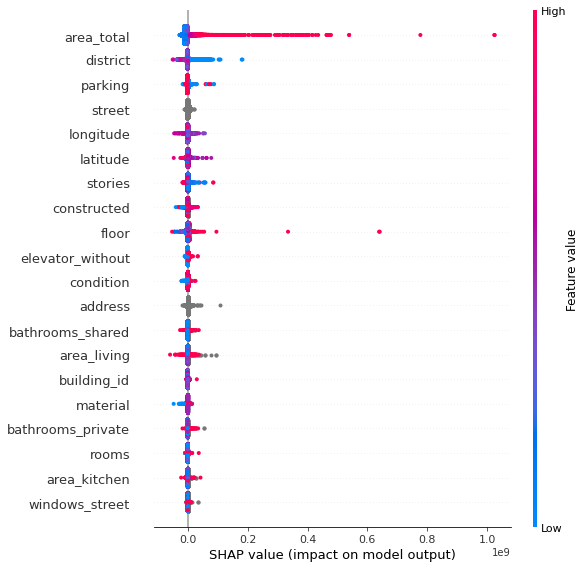

In [ ]:
shap.summary_plot(shap_values,X_train) # Shap analysis for feature importance

In [ ]:
print(model.score(X_train, y_train))

0.9962548230256774


In [ ]:
from sklearn.metrics import r2_score

y_pred = model.predict(X_val)
y_pred = y_pred.astype(int)
print(model.score(X_val, y_val)), print(r2_score(y_pred, model.predict(X_val)))

0.658197888855532
0.9999999999999998


(None, None)

In [ ]:
df=pd.DataFrame({'Actual': y_val, 'Predicted':y_pred})
df

,Actual,Predicted
0,50000000.0,53434130
1,39990000.0,47483828
2,11270000.0,8918563
3,11950000.0,12083362
4,53000000.0,100017270
...,...,...
4652,7131389.0,7645816
4653,138000000.0,270562957
4654,10700000.0,13194645
4655,11308500.0,11283496


In [ ]:
final_labels = model.predict(X1_test)
final_labels = final_labels.astype(float)
final_labels

array([23214903.87446136,  9380401.92280364,  5558347.28951508, ...,
        9479162.66971048, 14087014.27630249,  7760121.05838397])

In [ ]:
y_train_hat = model.predict(X_train)
y_valid_hat = model.predict(X_val)
#print(f'Train RMSLE: {root_mean_squared_log_error(y_true=y_train, y_pred=y_train_hat) :.4f}')
print(f'Valid RMSLE: {root_mean_squared_log_error(y_true=y_val, y_pred=y_valid_hat) :.4f}')

Valid RMSLE: 0.1690


In [ ]:
final_result = pd.DataFrame({'id': data_test['id'], 'price': final_labels})

In [ ]:
final_result.to_csv('submission.csv', index=False)

In [ ]:
submission = pd.read_csv("submission.csv")
submission

,id,price
0,23285,2.321490e+07
1,23286,9.380402e+06
2,23287,5.558347e+06
3,23288,1.102004e+07
4,23289,5.477607e+06
...,...,...
9932,33217,3.201060e+07
9933,33218,3.014273e+07
9934,33219,9.479163e+06
9935,33220,1.408701e+07


In [ ]:
submission = pd.DataFrame()
submission['id'] = data_test.id
submission['price_prediction'] = final_labels # Predict on non-nan entries
 
print(f'Generated {len(submission)} predictions')

# Export submission to csv with headers
#submission.to_csv('sample_submission.csv', index=False)

submission.to_csv('sample_submission.csv', index=False)

# Look at submitted csv
print('\nLine count of submission')
!wc -l sample_submission.csv

print('\nFirst 5 rows of submission')
!head -n 5 sample_submission.csv

Generated 9937 predictions

Line count of submission
9938 sample_submission.csv

First 5 rows of submission
id,price_prediction
23285,23214903.874461357
23286,9380401.92280364
23287,5558347.289515078
23288,11020044.952067383


In [ ]:
!pip install -r requirements.txt

You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [ ]:
import json
import pandas as pd
import numpy as np
import math as math
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.model_selection as model_selection
import sklearn.tree as tree
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
import time
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
!pip install impyute



You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [ ]:
apartments = pd.read_csv('apartments_train.csv')
#print(f'Loaded {len(apartments)} apartments')
with open('apartments_meta.json') as f: 
    apartments_meta = json.load(f)
#describe_data(apartments, apartments_meta)
buildings = pd.read_csv('buildings_train.csv')
#print(f'Loaded {len(buildings)} buildings')
with open('buildings_meta.json') as f: 
    buildings_meta = json.load(f)
#print(f'All apartments have an associated building: {apartments.building_id.isin(buildings.id).all()}')
df = pd.merge(apartments, buildings.set_index('id'), how='left', left_on='building_id', right_index=True)
df.head()

,id,seller,price,area_total,area_kitchen,area_living,floor,rooms,layout,ceiling,...,address,constructed,material,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,heating
0,0,3.0,7139520.0,59.2,12.5,31.0,2.0,2.0,NaN,2.65,...,к2.5/2,2021.0,3.0,9.0,0.0,1.0,1.0,1.0,NaN,NaN
1,1,NaN,10500000.0,88.0,14.2,48.0,18.0,3.0,1.0,NaN,...,14к3,2010.0,3.0,25.0,0.0,1.0,1.0,1.0,NaN,0.0
2,2,3.0,9019650.0,78.5,22.5,40.8,12.0,3.0,NaN,2.65,...,38,2021.0,3.0,15.0,0.0,1.0,1.0,1.0,NaN,NaN
3,3,NaN,10500000.0,88.0,14.0,48.0,18.0,3.0,NaN,NaN,...,14к3,2010.0,3.0,25.0,0.0,1.0,1.0,1.0,NaN,0.0
4,4,NaN,13900000.0,78.0,17.0,35.0,7.0,2.0,1.0,2.90,...,1к3,2017.0,2.0,15.0,0.0,1.0,1.0,1.0,0.0,0.0


In [ ]:
df.isnull().sum()

id                        0
seller                 8830
price                     0
area_total                0
area_kitchen           4721
area_living            3882
floor                     0
rooms                     0
layout                17642
ceiling               11093
bathrooms_shared       3872
bathrooms_private      3872
windows_court          8072
windows_street         8072
balconies             10520
loggias               10520
condition              9810
phones                   80
building_id               0
new                     264
latitude                  0
longitude                 0
district                130
street                    0
address                   0
constructed             794
material               3972
stories                   0
elevator_without        357
elevator_passenger      357
elevator_service        357
parking                6788
garbage_chute          8811
heating                8161
dtype: int64

<AxesSubplot:>

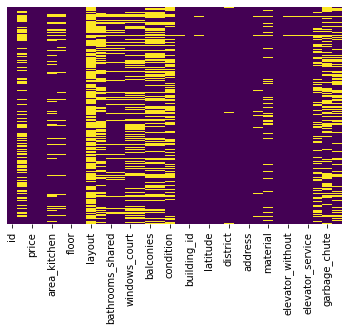

In [ ]:
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis') # Heatmap to better visualize missing values

In [ ]:
df.shape


(23285, 34)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23285 entries, 0 to 23284
Data columns (total 34 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  23285 non-null  int64  
 1   seller              14455 non-null  float64
 2   price               23285 non-null  float64
 3   area_total          23285 non-null  float64
 4   area_kitchen        18564 non-null  float64
 5   area_living         19403 non-null  float64
 6   floor               23285 non-null  float64
 7   rooms               23285 non-null  float64
 8   layout              5643 non-null   float64
 9   ceiling             12192 non-null  float64
 10  bathrooms_shared    19413 non-null  float64
 11  bathrooms_private   19413 non-null  float64
 12  windows_court       15213 non-null  float64
 13  windows_street      15213 non-null  float64
 14  balconies           12765 non-null  float64
 15  loggias             12765 non-null  float64
 16  cond

In [ ]:
# drop:['seller', 'layout', 'ceiling', 'balconies', 'loggias', 'condition', 'garbage_chute', 'heating'], axis=1)
# First attmept at imputing nan-values based on intuition
def clean_data(data):
    nan_replacements = [
        # ('floor', 0), #no nans
        # ('rooms', 1), #no nans
        ('ceiling', data['ceiling'].mean()),
        #('bathrooms_shared',),
        #('bathrooms_private',),
        ('condition', 3),
        ('phones', 1),
        ('new', 0),
        #('contructed',),
        ('material', 2),
        ('elevator_without', 0),
        ('elevator_passenger', 1),
        ('elevator_service', 0),
        ('parking', 1),
        ('garbage_chute', 0),
        ('heating', 0),
        ('balconies', 0),
        ('loggias', 0),
        ('seller', 2),
        ('district', 2), #idk change
    ]

    for feature, value in nan_replacements:
        data[feature] = data[feature].fillna(value)

    return data

In [ ]:
df.isnull().sum()

#seller, layout, 

id                        0
seller                 8830
price                     0
area_total                0
area_kitchen           4721
area_living            3882
floor                     0
rooms                     0
layout                17642
ceiling               11093
bathrooms_shared       3872
bathrooms_private      3872
windows_court          8072
windows_street         8072
balconies             10520
loggias               10520
condition              9810
phones                   80
building_id               0
new                     264
latitude                  0
longitude                 0
district                130
street                    0
address                   0
constructed             794
material               3972
stories                   0
elevator_without        357
elevator_passenger      357
elevator_service        357
parking                6788
garbage_chute          8811
heating                8161
dtype: int64

In [ ]:
c = [2999,
 3059,
 3102,
 3543,
 3551,
 3556,
 3557,
 3559,
 8308,
 8312,
 10300,
 10317,
 10932,
 10933,
 11247,
 12619,
 15761,
 15828,
 15840,
 16683,
 18232,
 19028,
 21534,
 21538,
 2215,
 2236,
 2241,
 2363,
 7512,
 7513,
 7514,
 7572,
 11167,
 13201,
 13206,
 13207,
 13642,
 13724,
 13725,
 16636,
 20314,
 20317,
 20329,
 20333,
 21393,
 21407,
 22401,
 23222]
a = df.shape
df.drop(c, axis=0, inplace=True)
b = df.shape
a,b

((23285, 34), (23237, 34))

In [ ]:
df0 = df.drop(['street', 'address'], axis=1)
df0.columns

Index(['id', 'seller', 'price', 'area_total', 'area_kitchen', 'area_living',
       'floor', 'rooms', 'layout', 'ceiling', 'bathrooms_shared',
       'bathrooms_private', 'windows_court', 'windows_street', 'balconies',
       'loggias', 'condition', 'phones', 'building_id', 'new', 'latitude',
       'longitude', 'district', 'constructed', 'material', 'stories',
       'elevator_without', 'elevator_passenger', 'elevator_service', 'parking',
       'garbage_chute', 'heating'],
      dtype='object')

In [ ]:
import sys
#from impyute.imputation.cs import fast_knn
# 'seller', 'layout', 'ceiling', 'balconies', 'loggias', 'condition', 'garbage_chute', 'heating'

sys.setrecursionlimit(100000) #Increase the recursion limit of the OS

# start the KNN training
#imputed_training=fast_knn(df.values, k=30)
imputer = KNNImputer()
imputer.fit(df0)
dftrans = imputer.transform(df0)


In [ ]:
"""
df = df.drop(['seller', 'layout', 'ceiling', 'balconies', 'loggias', 'condition', 'garbage_chute', 'heating'], axis=1)

df.area_kitchen.fillna(df.area_total *0.20382557322076747, inplace=True)
df.area_living.fillna(df.area_total *0.5489437954371277, inplace=True)
df.bathrooms_shared.fillna(df.bathrooms_shared.mode()[0], inplace = True)
df.bathrooms_private.fillna(df.bathrooms_private.mode()[0], inplace = True)
df.windows_court.fillna(df.windows_court.mode()[0], inplace = True)
df.windows_street.fillna(df.windows_street.mode()[0], inplace = True)
df.phones.fillna(df.phones.mode()[0], inplace=True)
df.new.fillna(df.new.mode()[0], inplace = True)
df.latitude.fillna(df.latitude.mean(), inplace = True)
df.longitude.fillna(df.longitude.mean(), inplace = True)
df.district.fillna(df.district.mode()[0], inplace = True)
df.constructed.fillna(df.constructed.mode()[0], inplace = True)
df.material.fillna(df.material.mode()[0], inplace = True)
df.elevator_without.fillna(df.elevator_without.mode()[0], inplace = True)
df.elevator_passenger.fillna(df.elevator_passenger.mode()[0], inplace = True)
df.elevator_service.fillna(df.elevator_service.mode()[0], inplace = True)
df.parking.fillna(df.parking.mode()[0], inplace = True)
df.shape
df.isnull().sum()
"""

"\ndf = df.drop(['seller', 'layout', 'ceiling', 'balconies', 'loggias', 'condition', 'garbage_chute', 'heating'], axis=1)\n\ndf.area_kitchen.fillna(df.area_total *0.20382557322076747, inplace=True)\ndf.area_living.fillna(df.area_total *0.5489437954371277, inplace=True)\ndf.bathrooms_shared.fillna(df.bathrooms_shared.mode()[0], inplace = True)\ndf.bathrooms_private.fillna(df.bathrooms_private.mode()[0], inplace = True)\ndf.windows_court.fillna(df.windows_court.mode()[0], inplace = True)\ndf.windows_street.fillna(df.windows_street.mode()[0], inplace = True)\ndf.phones.fillna(df.phones.mode()[0], inplace=True)\ndf.new.fillna(df.new.mode()[0], inplace = True)\ndf.latitude.fillna(df.latitude.mean(), inplace = True)\ndf.longitude.fillna(df.longitude.mean(), inplace = True)\ndf.district.fillna(df.district.mode()[0], inplace = True)\ndf.constructed.fillna(df.constructed.mode()[0], inplace = True)\ndf.material.fillna(df.material.mode()[0], inplace = True)\ndf.elevator_without.fillna(df.elevator

In [ ]:
"""df.elevator_without = df.elevator_without.astype(int)
df.floor = df.floor.astype(int)
df.rooms = df.rooms.astype(int)
df.bathrooms_shared = df.bathrooms_shared.astype(int)
df.bathrooms_private = df.bathrooms_private.astype(int)
df.windows_court = df.windows_court.astype(int)
df.windows_street = df.windows_street.astype(int)
df.phones = df.phones.astype(int)
df.new = df.new.astype(int)
df.district = df.district.astype(int)
df.constructed = df.constructed.astype(int)
df.material = df.material.astype(int)
df.stories = df.stories.astype(int)
df.elevator_without = df.elevator_without.astype(int)
df.elevator_passenger = df.elevator_passenger.astype(int)
df.elevator_service = df.elevator_service.astype(int)
df.parking = df.parking.astype(int)
"""

'df.elevator_without = df.elevator_without.astype(int)\ndf.floor = df.floor.astype(int)\ndf.rooms = df.rooms.astype(int)\ndf.bathrooms_shared = df.bathrooms_shared.astype(int)\ndf.bathrooms_private = df.bathrooms_private.astype(int)\ndf.windows_court = df.windows_court.astype(int)\ndf.windows_street = df.windows_street.astype(int)\ndf.phones = df.phones.astype(int)\ndf.new = df.new.astype(int)\ndf.district = df.district.astype(int)\ndf.constructed = df.constructed.astype(int)\ndf.material = df.material.astype(int)\ndf.stories = df.stories.astype(int)\ndf.elevator_without = df.elevator_without.astype(int)\ndf.elevator_passenger = df.elevator_passenger.astype(int)\ndf.elevator_service = df.elevator_service.astype(int)\ndf.parking = df.parking.astype(int)\n'

In [ ]:
df1 = pd.DataFrame(dftrans, columns=list(df0.columns.values))

In [ ]:
"""df1.elevator_without = df1.elevator_without.astype(int)
df1.floor = df1.floor.astype(int)
df1.rooms = df1.rooms.astype(int)
df1.bathrooms_shared = df1.bathrooms_shared.astype(int)
df1.bathrooms_private = df1.bathrooms_private.astype(int)
df1.windows_court = df1.windows_court.astype(int)
df1.windows_street = df1.windows_street.astype(int)
df1.phones = df1.phones.astype(int)
df1.new = df1.new.astype(int)
df1.district = df1.district.astype(int)
df1.constructed = df1.constructed.astype(int)
df1.material = df1.material.astype(int)
df1.stories = df1.stories.astype(int)
df1.elevator_without = df1.elevator_without.astype(int)
df1.elevator_passenger = df1.elevator_passenger.astype(int)
df1.elevator_service = df1.elevator_service.astype(int)
df1.parking = df1.parking.astype(int)
df1.garbage_chute = df1.garbage_chute.astype(int)
df1.heating = df1.heating.astype(int)
df1.building_id = df1.building_id.astype(int)
df1.condition = df1.condition.astype(int)
df1.loggias = df1.loggias.astype(int)
df1.balconies = df1.balconies.astype(int)
#df1.ceiling = df1.ceiling.round(0)
#df1.ceiling = df1.ceiling.astype(int)"""




'df1.elevator_without = df1.elevator_without.astype(int)\ndf1.floor = df1.floor.astype(int)\ndf1.rooms = df1.rooms.astype(int)\ndf1.bathrooms_shared = df1.bathrooms_shared.astype(int)\ndf1.bathrooms_private = df1.bathrooms_private.astype(int)\ndf1.windows_court = df1.windows_court.astype(int)\ndf1.windows_street = df1.windows_street.astype(int)\ndf1.phones = df1.phones.astype(int)\ndf1.new = df1.new.astype(int)\ndf1.district = df1.district.astype(int)\ndf1.constructed = df1.constructed.astype(int)\ndf1.material = df1.material.astype(int)\ndf1.stories = df1.stories.astype(int)\ndf1.elevator_without = df1.elevator_without.astype(int)\ndf1.elevator_passenger = df1.elevator_passenger.astype(int)\ndf1.elevator_service = df1.elevator_service.astype(int)\ndf1.parking = df1.parking.astype(int)\ndf1.garbage_chute = df1.garbage_chute.astype(int)\ndf1.heating = df1.heating.astype(int)\ndf1.building_id = df1.building_id.astype(int)\ndf1.condition = df1.condition.astype(int)\ndf1.loggias = df1.logg

In [ ]:
df1.head()

,id,seller,price,area_total,area_kitchen,area_living,floor,rooms,layout,ceiling,...,district,constructed,material,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,heating
0,0.0,3.0,7139520.0,59.2,12.5,31.0,2.0,2.0,0.6,2.650,...,11.0,2021.0,3.0,9.0,0.0,1.0,1.0,1.0,1.0,0.4
1,1.0,0.4,10500000.0,88.0,14.2,48.0,18.0,3.0,1.0,2.744,...,2.0,2010.0,3.0,25.0,0.0,1.0,1.0,1.0,1.0,0.0
2,2.0,3.0,9019650.0,78.5,22.5,40.8,12.0,3.0,0.8,2.650,...,6.0,2021.0,3.0,15.0,0.0,1.0,1.0,1.0,0.2,0.4
3,3.0,0.4,10500000.0,88.0,14.0,48.0,18.0,3.0,1.0,2.744,...,2.0,2010.0,3.0,25.0,0.0,1.0,1.0,1.0,1.0,0.0
4,4.0,1.4,13900000.0,78.0,17.0,35.0,7.0,2.0,1.0,2.900,...,11.0,2017.0,2.0,15.0,0.0,1.0,1.0,1.0,0.0,0.0


In [ ]:
#names = list(df0.columns.values)

#names.remove('street')
#print(names)
#list1 = [21, 20, 5, 4, 3, 2, 0]
names = ['seller', 'floor', 'rooms', 'layout', 'ceiling', 
'bathrooms_shared', 'bathrooms_private', 'windows_court', 'windows_street', 'balconies', 'loggias', 'condition', 
'phones', 'building_id', 'new', 'district', 'constructed', 'material', 'stories', 'elevator_without', 
'elevator_passenger', 'elevator_service', 'parking', 'garbage_chute', 'heating']

#for l in list1:
#    names.pop(l)
print(names)

NameError: name 'names' is not defined

In [ ]:
names = ['seller', 'floor', 'rooms', 'layout', 'ceiling', 
'bathrooms_shared', 'bathrooms_private', 'windows_court', 'windows_street', 'balconies', 'loggias', 'condition', 
'phones', 'building_id', 'new', 'district', 'constructed', 'material', 'stories', 'elevator_without', 
'elevator_passenger', 'elevator_service', 'parking', 'garbage_chute', 'heating']
for x in names:
    df1[x] = df1[x].round(decimals = 0)
    df1[x] = df1[x].astype(int)

In [ ]:

df1['id'] = df1['id'].astype(int) # Casting everything except real numbers into float so that the boosting algorithms understand that they are encoded categories
df1['street'] = df.street
df1.head()

,id,seller,price,area_total,area_kitchen,area_living,floor,rooms,layout,ceiling,...,constructed,material,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,heating,street
0,0,3,7139520.0,59.2,12.5,31.0,2,2,1,3,...,2021,3,9,0,1,1,1,1,0,Бунинские Луга ЖК
1,1,0,10500000.0,88.0,14.2,48.0,18,3,1,3,...,2010,3,25,0,1,1,1,1,0,улица Радужная
2,2,3,9019650.0,78.5,22.5,40.8,12,3,1,3,...,2021,3,15,0,1,1,1,0,0,Саларьево Парк ЖК
3,3,0,10500000.0,88.0,14.0,48.0,18,3,1,3,...,2010,3,25,0,1,1,1,1,0,улица Радужная
4,4,1,13900000.0,78.0,17.0,35.0,7,2,1,3,...,2017,2,15,0,1,1,1,0,0,улица Сервантеса


In [ ]:
df1.to_csv('Training_clean5.csv', index=False)
df1.head()

,id,seller,price,area_total,area_kitchen,area_living,floor,rooms,layout,ceiling,...,constructed,material,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,heating,street
0,0,3,7139520.0,59.2,12.5,31.0,2,2,1,3,...,2021,3,9,0,1,1,1,1,0,Бунинские Луга ЖК
1,1,0,10500000.0,88.0,14.2,48.0,18,3,1,3,...,2010,3,25,0,1,1,1,1,0,улица Радужная
2,2,3,9019650.0,78.5,22.5,40.8,12,3,1,3,...,2021,3,15,0,1,1,1,0,0,Саларьево Парк ЖК
3,3,0,10500000.0,88.0,14.0,48.0,18,3,1,3,...,2010,3,25,0,1,1,1,1,0,улица Радужная
4,4,1,13900000.0,78.0,17.0,35.0,7,2,1,3,...,2017,2,15,0,1,1,1,0,0,улица Сервантеса


In [ ]:
df1.shape

(23237, 33)

In [ ]:
df1[df1.id==455]

,id,seller,price,area_total,area_kitchen,area_living,floor,rooms,layout,ceiling,...,constructed,material,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,heating,street
455,455,3,32268200.0,101.45,14.32,71.68,1,3,1,3,...,2011,2,18,0,1,1,0,1,0,улица Маршала Рыбалко


In [ ]:
import json
import pandas as pd
import numpy as np
import math as math
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import sklearn.model_selection as model_selection
import sklearn.tree as tree
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
import time
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
import xgboost
from sklearn.model_selection import RandomizedSearchCV




In [ ]:
data_train = pd.read_csv('Training_clean1.csv')
data_train = data_train.drop(['street', 'address'], axis=1)
data_test = pd.read_csv('Test_clean1.csv')
data_test = data_test.drop(['street', 'address'], axis=1)
data_train.head()
data_test.head()

,id,area_total,area_kitchen,area_living,floor,rooms,bathrooms_shared,bathrooms_private,windows_court,windows_street,...,latitude,longitude,district,constructed,material,stories,elevator_without,elevator_passenger,elevator_service,parking
0,23285,71.4,14.553146,39.194587,2,1,0,0,1,0,...,55.762247,37.549040,0,2017,2,20,1,1,1,0
1,23286,54.0,4.000000,50.000000,4,1,0,0,1,0,...,55.591467,37.452651,11,2017,2,15,0,1,1,0
2,23287,39.4,19.600000,11.200000,10,1,1,0,1,0,...,55.617017,37.413718,11,2021,3,9,0,1,1,1
3,23288,60.9,12.412977,33.430677,5,2,1,0,0,1,...,55.569052,37.479510,11,2014,2,17,1,1,0,0
4,23289,34.0,9.000000,17.000000,14,1,1,0,1,0,...,55.518041,37.343829,11,2016,2,17,0,1,1,0


In [ ]:
def root_mean_squared_log_error(y_true, y_pred):
    # Alternatively: sklearn.metrics.mean_squared_log_error(y_true, y_pred) ** 0.5
    assert (y_true >= 0).all() 
    assert (y_pred >= 0).all()
    log_error = np.log1p(y_pred) - np.log1p(y_true)  # Note: log1p(x) = log(1 + x)
    return np.mean(log_error ** 2) ** 0.5


In [ ]:
X = data_train.copy()
X_train, X_test = train_test_split(X, test_size=0.2, stratify=np.log(data_train.price).round())
y_train = X_train.price
y_test = X_test.price
X_train = X_train.drop(['id', 'price'], axis=1,inplace=True)
X_test = X_test.drop(['id', 'price'], axis=1, inplace=True)



In [ ]:
import xgboost
regressor=xgboost.XGBRegressor(objective='reg-linear', colsample_bytree=0.3, learning_rate = 0.1, max_depth = 5, alpha = 10, n_estimators =10)
regressor.fit(X_train, y_train)
a = regressor.predict(X_test)
b = root_mean_squared_log_error(y_test, a) 
# We used an online colab service that did not have the computing power to run xgb on the virtual machine, but we did it
# locally, and it was ouperformed by both lightgbm and catboost

KernelInterrupted: Execution interrupted by the Jupyter kernel.

In [ ]:
import time
try: 
    time.sleep(5)
    print('That was a nice nap.')
except KeyboardInterrupt:
    print('What a rude awakening!')

That was a nice nap.


In [ ]:
booster=["gbtree","gblinear"]
base_score=[0.25,0.5,0.75,1]

In [ ]:
#hyper parameter
n_estimators=[100,500,900,1100,1500]
max_depth=[2,3,5,10,15]
booster=["gbtree","gblinear"]
learning_rate=[0.05,0.1,0.15,0.20]
min_child_weight=[1,2,3,4]
base_score=[0.25,0.5,0.75,1]

org_params = {
    'n_estimators': n_estimators,
    'learning_rate': learning_rate,
    "booster":booster,
    'eval_metric': 'RMSE',
    'use_best_model': True,
    'loss_function': 'RMSE',
    'max_depth': max_depth,
    "min_child_weight":min_child_weight,
    "base_score":base_score
}


In [ ]:
random_cv=RandomizedSearchCV(estimator=regressor,
param_distributions=org_params,
cv=5,n_iter=50,
scoring="neg_mean_absolute_error",n_jobs=4,
verbose=5,
return_train_score=True,
random_state=42)

# Utilized both gridsearchcv and randomizedsearchcv as ways to tune hyperparameters


In [ ]:
random_cv.fit(X_train, y_train)

TypeError: Parameter value is not iterable or distribution (key='use_best_model', value=True)

In [ ]:
random_cv.best_estimator_

AttributeError: 'RandomizedSearchCV' object has no attribute 'best_estimator_'

In [ ]:
!pip install -r requirements.txt

You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [ ]:
import json
import pandas as pd
import numpy as np
import math as math
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.model_selection as model_selection
import sklearn.tree as tree
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
import time
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
import catboost
from catboost import CatBoostClassifier
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split


In [ ]:
df_train = pd.read_csv('Training_clean1.csv')
def root_mean_squared_log_error(y_true, y_pred):
    # Alternatively: sklearn.metrics.mean_squared_log_error(y_true, y_pred) ** 0.5
    assert (y_true >= 0).all() 
    assert (y_pred >= 0).all()
    log_error = np.log1p(y_pred) - np.log1p(y_true)  # Note: log1p(x) = log(1 + x)
    return np.mean(log_error ** 2) ** 0.5

df_test = pd.read_csv('Test_clean1.csv')
    


In [ ]:
# Tried feature enginnering a new feature that is the ratio of floor to total stories in building. Catboost did not 
# perform better with this, so we reverted back to seperate features for this one
df_train['floor/stories'] = df_train.floor/df_train.stories
df_test['floor/stories'] = df_test.floor/df_test.stories

# Create new feature that combines longitude and latitude to distance from center, in the shap analysis this seemed a better feature for catboost

df_train['distance'] = np.sqrt((37.6 - df_train['longitude'])**2 + (55.75 - df_train['latitude'])**2)
df_test['distance'] = np.sqrt((37.6 - df_test['longitude'])**2 + (55.75 - df_test['latitude'])**2)

df_train.drop(['floor', 'stories', 'longitude', 'latitude'], axis=1, inplace=True)
df_test.drop(['floor', 'stories', 'longitude', 'latitude'], axis=1, inplace=True)

In [ ]:
#y1 = df_train['price']
X1 = df_train.drop(['price', 'id', 'address'], axis=1)
X1_test = df_test.drop(['id', 'address'], axis=1)
X1_test_area_total = X1_test.area_total.values
df_train['price/area'] = df_train['price']/df_train['area_total']
y1 = df_train['price/area']
X1_test

,area_total,area_kitchen,area_living,rooms,bathrooms_shared,bathrooms_private,windows_court,windows_street,phones,building_id,...,district,street,constructed,material,elevator_without,elevator_passenger,elevator_service,parking,floor/stories,distance
0,71.4,14.553146,39.194587,1,0,0,1,0,1,5148,...,0,2-я Черногрязская улица,2017,2,1,1,1,0,0.100000,0.052411
1,54.0,4.000000,50.000000,1,0,0,1,0,1,1290,...,11,улица Сервантеса,2017,2,0,1,1,0,0.266667,0.216436
2,39.4,19.600000,11.200000,1,1,0,1,0,1,681,...,11,Саларьево Парк ЖК,2021,3,0,1,1,1,1.111111,0.228879
3,60.9,12.412977,33.430677,2,1,0,0,1,1,4261,...,11,улица Александры Монаховой,2014,2,1,1,0,0,0.294118,0.217394
4,34.0,9.000000,17.000000,1,1,0,1,0,1,7530,...,11,улица 3-я Нововатутинская,2016,2,0,1,1,0,0.823529,0.345584
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9932,106.0,19.900000,56.700000,3,0,0,1,0,1,4252,...,8,улица Паршина,2020,2,0,1,1,0,0.800000,0.148935
9933,82.0,16.713697,45.013391,3,2,0,1,0,2,7380,...,7,Западный Порт ЖК,2021,2,0,1,1,1,0.150000,0.083756
9934,49.3,10.048601,27.062929,1,0,0,1,0,1,1480,...,7,Рублевское шоссе,2016,2,0,1,1,0,0.625000,0.225713
9935,38.8,10.500000,15.100000,1,1,0,0,1,2,2154,...,5,улица Архитектора Щусева,2019,2,1,1,1,0,1.000000,0.062356


In [ ]:
#y1 = df_train.price.values
#X1 = df_train.drop(['id','price', 'street', 'address'], axis=1)
#X1_test = df_test.drop(['id', 'street', 'address'], axis=1)
#categorical_features_indices = np.where(X1.dtypes != np.float64)[0]
#categorical_features_indices = np.where(X1_test.dtypes != np.float64)[0]
cat_feature_indices = np.array([3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17])

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X1, y1, test_size=0.2, random_state=1, shuffle=True)
X_train.shape, X_val.shape, y_train.shape,y_val.shape, X1_test.shape


((18628, 21), (4657, 21), (18628,), (4657,), (9937, 21))

In [ ]:
# Drop are_total, price
# Kepp area_total as numpy arrays 

In [ ]:
area_total_train = X_train.area_total.values
area_total_val = X_val.area_total.values
X_train = X_train.drop(['area_total'], axis=1)
X_val = X_val.drop(['area_total'], axis=1)
X_train.head()

,area_kitchen,area_living,rooms,bathrooms_shared,bathrooms_private,windows_court,windows_street,phones,building_id,new,district,street,constructed,material,elevator_without,elevator_passenger,elevator_service,parking,floor/stories,distance
16628,6.00000,33.000000,2,0,1,1,1,1,674,0,8,улица Центральная,1977,3,1,0,0,1,0.800000,0.236988
19292,5.40000,20.000000,1,0,0,1,0,1,5284,0,2,улица Бочкова,1963,4,1,0,0,1,0.200000,0.067063
6194,7.25619,19.542399,1,1,0,1,0,1,8601,1,11,Сосенское поселение,2020,2,1,1,1,1,0.166667,0.228344
14066,9.00000,21.000000,1,0,1,1,0,1,6746,0,6,Старобитцевская улица,1992,3,0,1,1,1,0.785714,0.174128
6790,6.80000,48.900000,2,1,2,1,1,1,2500,1,1,Ленинградский проспект,2020,2,0,1,0,0,0.048780,0.069788


In [ ]:
#hyper parameter
n_estimators=[100,500,900,1100,1500]
max_depth=[2,3,5,10,15]
booster=["gbtree","gblinear"]
learning_rate="[0.05,0.1,0.15,0.20]"
min_child_weight=[1,2,3,4]
base_score=[0.25,0.5,0.75,1]

org_params = {
    'n_estimators': n_estimators,
    'learning_rate': learning_rate,
    "booster":booster,
    'eval_metric': 'RMSE',
    'use_best_model': True,
    'loss_function': 'RMSE',
    'max_depth': max_depth,
    "min_child_weight":min_child_weight,
    "base_score":base_score
}

In [ ]:
from catboost import CatBoostRegressor
#random_state=1, iterations=1500, depth=8, learning_rate=.1, loss_function='RMSE'
model = CatBoostRegressor(random_state=1, iterations=2000,cat_features = cat_feature_indices, depth=9, learning_rate=0.1, loss_function='RMSE')
model.fit(X_train, y_train, eval_set=(X_val, y_val),plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

1006:	learn: 23314.5972404	test: 74495.2002390	best: 74495.2002390 (1006)	total: 2m	remaining: 1m 58s
1007:	learn: 23305.6828956	test: 74496.1202954	best: 74495.2002390 (1006)	total: 2m	remaining: 1m 58s
1008:	learn: 23298.9816887	test: 74498.4551782	best: 74495.2002390 (1006)	total: 2m	remaining: 1m 58s
1009:	learn: 23288.1323131	test: 74495.9227270	best: 74495.2002390 (1006)	total: 2m	remaining: 1m 58s
1010:	learn: 23274.3003793	test: 74495.4046122	best: 74495.2002390 (1006)	total: 2m	remaining: 1m 58s
1011:	learn: 23261.3600623	test: 74487.9546894	best: 74487.9546894 (1011)	total: 2m 1s	remaining: 1m 58s
1012:	learn: 23244.5181148	test: 74482.3521852	best: 74482.3521852 (1012)	total: 2m 1s	remaining: 1m 58s
1013:	learn: 23233.6208420	test: 74478.0156516	best: 74478.0156516 (1013)	total: 2m 1s	remaining: 1m 57s
1014:	learn: 23230.0226570	test: 74478.7494537	best: 74478.0156516 (1013)	total: 2m 1s	remaining: 1m 57s
1015:	learn: 23225.0675892	test: 74478.0159658	best: 74478.0156516 (10

In [ ]:
print(model.score(X_train, y_train))
from sklearn.metrics import r2_score

y_pred = model.predict(X_val)
y_pred = y_pred.astype(float)
print(model.score(X_val, y_val)), print(r2_score(y_pred, model.predict(X_val)))

0.9598727405713643
0.8111237560278827
1.0


(None, None)

In [ ]:
df=pd.DataFrame({'Actual': y_val, 'Predicted':y_pred})
df

,Actual,Predicted
10307,641025.641026,628101.786351
2684,370277.777778,410751.350293
15931,213851.992410,183403.999139
10683,187598.116170,179337.453662
22217,189556.509299,460509.511372
...,...,...
5606,119453.752094,137121.613124
8243,500000.000000,772104.667444
13490,163109.756098,176523.018989
7008,179500.000000,164605.241542


In [ ]:
final_labels = model.predict(X1_test.drop(['area_total'], axis=1))
final_labels = final_labels.astype(float)
final_labels

array([411543.07217793, 177145.8460152 , 165676.5618941 , ...,
       215995.07915192, 249824.67965253, 102640.29838745])

In [ ]:

final_labels = final_labels * df_test.area_total.values
len(final_labels)

9937

In [ ]:
df_train.area_total.values

array([ 59.2,  88. ,  78.5, ...,  73.4, 100.8,  57.7])

In [ ]:
y_train_hat = model.predict(X_train) * area_total_train ## * edit
y_valid_hat = model.predict(X_val) * area_total_val ## * edit

y_train = y_train * area_total_train ## edit
y_val = y_val * area_total_val ## edit

print(f'Train RMSLE: {root_mean_squared_log_error(y_true=y_train, y_pred=y_train_hat) :.4f}')
print(f'Valid RMSLE: {root_mean_squared_log_error(y_true=y_val, y_pred=y_valid_hat) :.4f}')

#Train RMSLE: 0.1283
#Valid RMSLE: 0.1761

#Train RMSLE: 0.0489
#Valid RMSLE: 0.1451

Train RMSLE: 0.0987
Valid RMSLE: 0.1479


In [ ]:
submission = pd.DataFrame()
submission['id'] = df_test.id
submission['price_prediction'] = final_labels # Predict on non-nan entries
 # Fill missing entries with mean predictor
print(f'Generated {len(submission)} predictions')

# Export submission to csv with headers
#submission.to_csv('sample_submission.csv', index=False)

submission.to_csv('sample_submission9.csv', index=False)

Generated 9937 predictions


In [ ]:
# SHAP analysis


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=99c1e030-46bc-40fa-835c-0661eae0d488' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>